# Bayesian Neural Networks

## 1. Binary Classification


In [1]:
%matplotlib inline
import theano
import tensorflow as tf
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from keras.models import Sequential
from keras.layers import Activation, Dense
from pymc3.theanof import set_tt_rng, MRG_RandomStreams

Using TensorFlow backend.


In [2]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

Generate some data for binary classification that’s not linearly separable

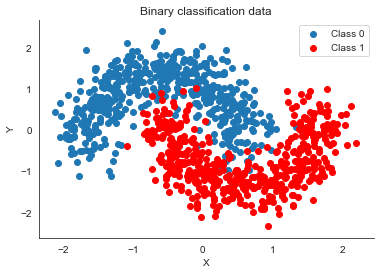

In [3]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Binary classification data');

First, we create the Bayesian neural network, and then the normal neural network.

In [5]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5 #number of hidden neurons

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        #inputs and outputs are shared variables
        ann_input = pm.Data('ann_input', X_train)
        ann_output = pm.Data('ann_output', Y_train)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] 
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

In [6]:
set_tt_rng(MRG_RandomStreams(42))
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)

Average Loss = 127.63: 100%|████████████████████████████████████████████████████| 30000/30000 [00:34<00:00, 881.51it/s]
Finished [100%]: Average Loss = 127.75


In [7]:
trace = approx.sample(draws=5000)
#neural_network.out.distribution.p

sigmoid.0

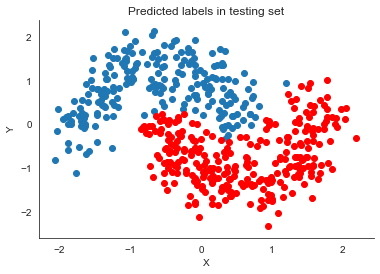

In [10]:
x = T.matrix('X')
n = T.iscalar('n')
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n,
                                   more_replacements={neural_network['ann_input']: x})
#compile the function
sample_proba = theano.function([x, n], _sample_proba)

# Create bechmark functions
def production_step1():
    pm.set_data(new_data={'ann_input': X_test, 'ann_output': Y_test}, model=neural_network)
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)

    # Use probability of > 0.5 to assume prediction of class 1
    pred = ppc['out'].mean(axis=0) > 0.5

def production_step2():
    sample_proba(X_test, 500).mean(0) > 0.5
    
pred = sample_proba(X_test, 500).mean(0) > 0.5
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [11]:
#generate predictions
pred = sample_proba(X_test, 500).mean(0) > 0.5
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 92.80000000000001%


Average Loss = 119.25: 100%|████████████████████████████████████████████████████| 40000/40000 [00:45<00:00, 884.04it/s]
Finished [100%]: Average Loss = 119.23


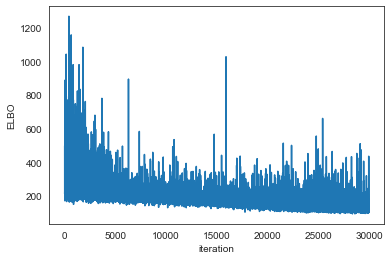

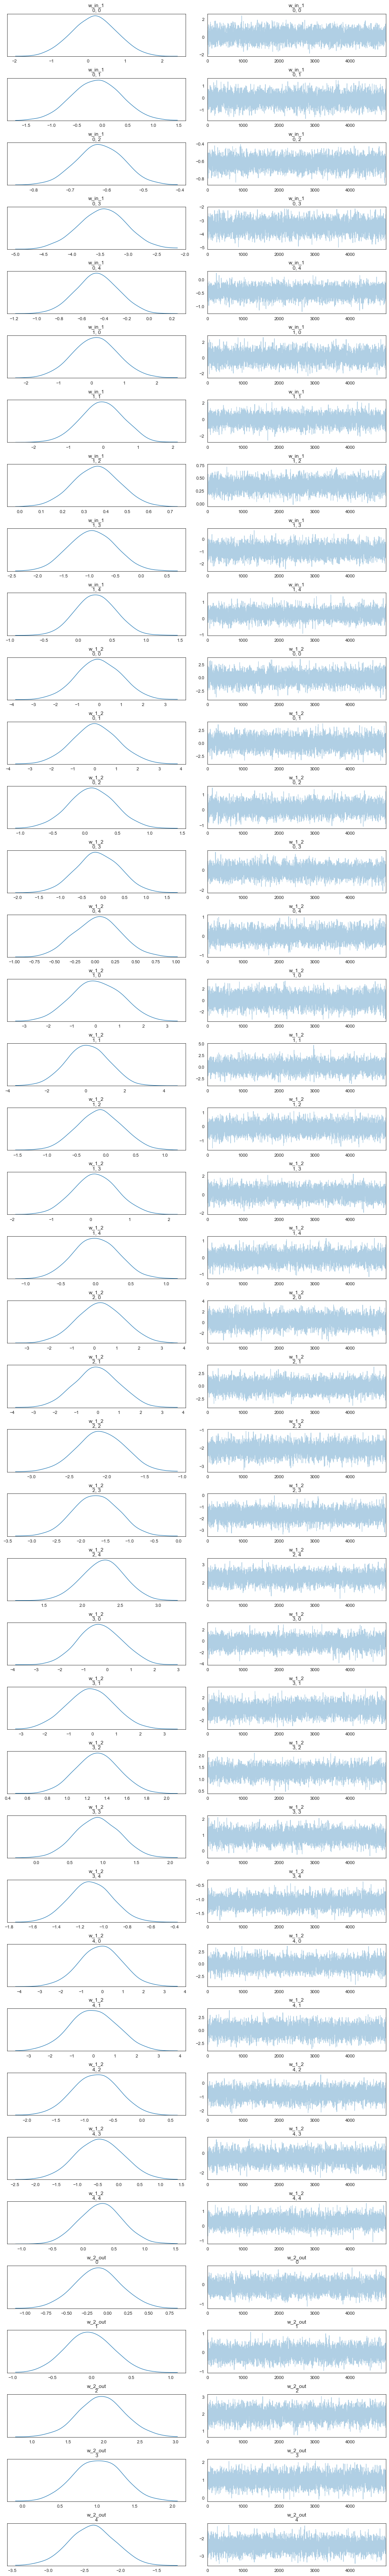

In [12]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    approx = pm.fit(40000, method=pm.ADVI())
plt.plot(inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');
pm.traceplot(trace);

Define the Keras model:

In [47]:
model = Sequential()
model.add(Dense(5, input_dim=2, activation='tanh'))
model.add(Dense(5, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=4000)

Epoch 1/4000
50/50 [==============================] - ETA: 0s - loss: 0.5266 - accuracy: 0.18 - 0s 8ms/step - loss: 0.4407 - accuracy: 0.2200
Epoch 2/4000
50/50 [==============================] - ETA: 0s - loss: 0.4579 - accuracy: 0.25 - 0s 260us/step - loss: 0.4273 - accuracy: 0.2000
Epoch 3/4000
50/50 [==============================] - ETA: 0s - loss: 0.4143 - accuracy: 0.15 - 0s 540us/step - loss: 0.4146 - accuracy: 0.2000
Epoch 4/4000
50/50 [==============================] - ETA: 0s - loss: 0.4165 - accuracy: 0.18 - 0s 160us/step - loss: 0.4005 - accuracy: 0.2000
Epoch 5/4000
50/50 [==============================] - ETA: 0s - loss: 0.4410 - accuracy: 0.18 - 0s 260us/step - loss: 0.3864 - accuracy: 0.2000
Epoch 6/4000
50/50 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.25 - 0s 160us/step - loss: 0.3744 - accuracy: 0.2000
Epoch 7/4000
50/50 [==============================] - ETA: 0s - loss: 0.3056 - accuracy: 0.12 - 0s 160us/step - loss: 0.3616 - accuracy: 0

50/50 [==============================] - ETA: 0s - loss: -0.4869 - accuracy: 0.218 - 0s 140us/step - loss: -0.0841 - accuracy: 0.2000
Epoch 58/4000
50/50 [==============================] - ETA: 0s - loss: -0.0247 - accuracy: 0.218 - 0s 180us/step - loss: -0.0919 - accuracy: 0.2000
Epoch 59/4000
50/50 [==============================] - ETA: 0s - loss: -0.3766 - accuracy: 0.218 - 0s 260us/step - loss: -0.0977 - accuracy: 0.2000
Epoch 60/4000
50/50 [==============================] - ETA: 0s - loss: -0.2835 - accuracy: 0.156 - 0s 220us/step - loss: -0.1044 - accuracy: 0.2000
Epoch 61/4000
50/50 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.21 - 0s 220us/step - loss: -0.1117 - accuracy: 0.2000
Epoch 62/4000
50/50 [==============================] - ETA: 0s - loss: -0.3280 - accuracy: 0.218 - 0s 200us/step - loss: -0.1171 - accuracy: 0.2000
Epoch 63/4000
50/50 [==============================] - ETA: 0s - loss: -0.2666 - accuracy: 0.187 - 0s 240us/step - loss: -0.1237

50/50 [==============================] - ETA: 0s - loss: -1.0397 - accuracy: 0.218 - 0s 180us/step - loss: -0.4235 - accuracy: 0.2200
Epoch 113/4000
50/50 [==============================] - ETA: 0s - loss: -0.1425 - accuracy: 0.218 - 0s 200us/step - loss: -0.4305 - accuracy: 0.2200
Epoch 114/4000
50/50 [==============================] - ETA: 0s - loss: -0.7782 - accuracy: 0.250 - 0s 200us/step - loss: -0.4360 - accuracy: 0.2200
Epoch 115/4000
50/50 [==============================] - ETA: 0s - loss: -0.7234 - accuracy: 0.218 - 0s 200us/step - loss: -0.4421 - accuracy: 0.2200
Epoch 116/4000
50/50 [==============================] - ETA: 0s - loss: -0.2680 - accuracy: 0.281 - 0s 180us/step - loss: -0.4486 - accuracy: 0.2200
Epoch 117/4000
50/50 [==============================] - ETA: 0s - loss: -0.2775 - accuracy: 0.250 - 0s 180us/step - loss: -0.4546 - accuracy: 0.2200
Epoch 118/4000
50/50 [==============================] - ETA: 0s - loss: -0.5121 - accuracy: 0.218 - 0s 180us/step - loss:

50/50 [==============================] - ETA: 0s - loss: -1.0074 - accuracy: 0.156 - 0s 180us/step - loss: -0.7872 - accuracy: 0.2000
Epoch 168/4000
50/50 [==============================] - ETA: 0s - loss: -0.6024 - accuracy: 0.218 - 0s 180us/step - loss: -0.7949 - accuracy: 0.2000
Epoch 169/4000
50/50 [==============================] - ETA: 0s - loss: -1.1664 - accuracy: 0.156 - 0s 180us/step - loss: -0.8013 - accuracy: 0.2000
Epoch 170/4000
50/50 [==============================] - ETA: 0s - loss: -1.6009 - accuracy: 0.125 - 0s 180us/step - loss: -0.8083 - accuracy: 0.2000
Epoch 171/4000
50/50 [==============================] - ETA: 0s - loss: -1.1081 - accuracy: 0.218 - 0s 180us/step - loss: -0.8159 - accuracy: 0.2000
Epoch 172/4000
50/50 [==============================] - ETA: 0s - loss: -0.5105 - accuracy: 0.187 - 0s 180us/step - loss: -0.8230 - accuracy: 0.2000
Epoch 173/4000
50/50 [==============================] - ETA: 0s - loss: -0.9228 - accuracy: 0.218 - 0s 220us/step - loss:

Epoch 222/4000
50/50 [==============================] - ETA: 0s - loss: -1.1244 - accuracy: 0.250 - 0s 180us/step - loss: -1.1979 - accuracy: 0.2000
Epoch 223/4000
50/50 [==============================] - ETA: 0s - loss: -1.0395 - accuracy: 0.156 - 0s 180us/step - loss: -1.2054 - accuracy: 0.1800
Epoch 224/4000
50/50 [==============================] - ETA: 0s - loss: -1.4827 - accuracy: 0.156 - 0s 260us/step - loss: -1.2131 - accuracy: 0.1800
Epoch 225/4000
50/50 [==============================] - ETA: 0s - loss: -0.9357 - accuracy: 0.187 - 0s 200us/step - loss: -1.2213 - accuracy: 0.1800
Epoch 226/4000
50/50 [==============================] - ETA: 0s - loss: -1.7479 - accuracy: 0.156 - 0s 200us/step - loss: -1.2283 - accuracy: 0.1800
Epoch 227/4000
50/50 [==============================] - ETA: 0s - loss: -1.7307 - accuracy: 0.187 - 0s 180us/step - loss: -1.2361 - accuracy: 0.1800
Epoch 228/4000
50/50 [==============================] - ETA: 0s - loss: -1.1969 - accuracy: 0.250 - 0s 440

Epoch 277/4000
50/50 [==============================] - ETA: 0s - loss: -1.2505 - accuracy: 0.218 - 0s 240us/step - loss: -1.6074 - accuracy: 0.2000
Epoch 278/4000
50/50 [==============================] - ETA: 0s - loss: -1.9696 - accuracy: 0.218 - 0s 220us/step - loss: -1.6144 - accuracy: 0.2000
Epoch 279/4000
50/50 [==============================] - ETA: 0s - loss: -1.4959 - accuracy: 0.187 - 0s 320us/step - loss: -1.6220 - accuracy: 0.2000
Epoch 280/4000
50/50 [==============================] - ETA: 0s - loss: -1.9662 - accuracy: 0.218 - 0s 180us/step - loss: -1.6289 - accuracy: 0.2000
Epoch 281/4000
50/50 [==============================] - ETA: 0s - loss: -1.5318 - accuracy: 0.250 - 0s 200us/step - loss: -1.6364 - accuracy: 0.2000
Epoch 282/4000
50/50 [==============================] - ETA: 0s - loss: -1.5502 - accuracy: 0.218 - 0s 220us/step - loss: -1.6436 - accuracy: 0.2000
Epoch 283/4000
50/50 [==============================] - ETA: 0s - loss: -1.3321 - accuracy: 0.250 - 0s 240

Epoch 332/4000
50/50 [==============================] - ETA: 0s - loss: -2.2984 - accuracy: 0.062 - 0s 160us/step - loss: -1.9854 - accuracy: 0.2200
Epoch 333/4000
50/50 [==============================] - ETA: 0s - loss: -2.6169 - accuracy: 0.218 - 0s 160us/step - loss: -1.9920 - accuracy: 0.2200
Epoch 334/4000
50/50 [==============================] - ETA: 0s - loss: -2.1032 - accuracy: 0.187 - 0s 220us/step - loss: -1.9988 - accuracy: 0.2200
Epoch 335/4000
50/50 [==============================] - ETA: 0s - loss: -2.1266 - accuracy: 0.250 - 0s 140us/step - loss: -2.0053 - accuracy: 0.2200
Epoch 336/4000
50/50 [==============================] - ETA: 0s - loss: -2.8446 - accuracy: 0.218 - 0s 160us/step - loss: -2.0113 - accuracy: 0.2200
Epoch 337/4000
50/50 [==============================] - ETA: 0s - loss: -2.6116 - accuracy: 0.218 - 0s 160us/step - loss: -2.0179 - accuracy: 0.2200
Epoch 338/4000
50/50 [==============================] - ETA: 0s - loss: -1.9321 - accuracy: 0.312 - 0s 140

Epoch 387/4000
50/50 [==============================] - ETA: 0s - loss: -3.0066 - accuracy: 0.312 - 0s 180us/step - loss: -2.3378 - accuracy: 0.2800
Epoch 388/4000
50/50 [==============================] - ETA: 0s - loss: -2.7391 - accuracy: 0.281 - 0s 200us/step - loss: -2.3444 - accuracy: 0.2800
Epoch 389/4000
50/50 [==============================] - ETA: 0s - loss: -3.0107 - accuracy: 0.250 - 0s 160us/step - loss: -2.3508 - accuracy: 0.2800
Epoch 390/4000
50/50 [==============================] - ETA: 0s - loss: -1.1386 - accuracy: 0.343 - 0s 200us/step - loss: -2.3579 - accuracy: 0.2800
Epoch 391/4000
50/50 [==============================] - ETA: 0s - loss: -2.2052 - accuracy: 0.218 - 0s 180us/step - loss: -2.3638 - accuracy: 0.2800
Epoch 392/4000
50/50 [==============================] - ETA: 0s - loss: -1.9709 - accuracy: 0.312 - 0s 200us/step - loss: -2.3705 - accuracy: 0.2800
Epoch 393/4000
50/50 [==============================] - ETA: 0s - loss: -2.5128 - accuracy: 0.250 - 0s 200

Epoch 442/4000
50/50 [==============================] - ETA: 0s - loss: -2.5497 - accuracy: 0.531 - 0s 140us/step - loss: -2.6941 - accuracy: 0.4800
Epoch 443/4000
50/50 [==============================] - ETA: 0s - loss: -2.5611 - accuracy: 0.562 - 0s 200us/step - loss: -2.7004 - accuracy: 0.5000
Epoch 444/4000
50/50 [==============================] - ETA: 0s - loss: -2.5555 - accuracy: 0.500 - 0s 180us/step - loss: -2.7068 - accuracy: 0.5000
Epoch 445/4000
50/50 [==============================] - ETA: 0s - loss: -2.8456 - accuracy: 0.468 - 0s 180us/step - loss: -2.7131 - accuracy: 0.5000
Epoch 446/4000
50/50 [==============================] - ETA: 0s - loss: -2.2614 - accuracy: 0.500 - 0s 180us/step - loss: -2.7198 - accuracy: 0.5000
Epoch 447/4000
50/50 [==============================] - ETA: 0s - loss: -3.7165 - accuracy: 0.406 - 0s 180us/step - loss: -2.7256 - accuracy: 0.5000
Epoch 448/4000
50/50 [==============================] - ETA: 0s - loss: -3.1681 - accuracy: 0.468 - 0s 180

Epoch 497/4000
50/50 [==============================] - ETA: 0s - loss: -3.1939 - accuracy: 0.593 - 0s 160us/step - loss: -3.0459 - accuracy: 0.6200
Epoch 498/4000
50/50 [==============================] - ETA: 0s - loss: -2.9014 - accuracy: 0.656 - 0s 180us/step - loss: -3.0524 - accuracy: 0.6200
Epoch 499/4000
50/50 [==============================] - ETA: 0s - loss: -3.5213 - accuracy: 0.593 - 0s 180us/step - loss: -3.0585 - accuracy: 0.6200
Epoch 500/4000
50/50 [==============================] - ETA: 0s - loss: -2.8873 - accuracy: 0.625 - 0s 180us/step - loss: -3.0651 - accuracy: 0.6200
Epoch 501/4000
50/50 [==============================] - ETA: 0s - loss: -3.2466 - accuracy: 0.625 - 0s 200us/step - loss: -3.0713 - accuracy: 0.6200
Epoch 502/4000
50/50 [==============================] - ETA: 0s - loss: -3.8377 - accuracy: 0.531 - 0s 200us/step - loss: -3.0774 - accuracy: 0.6200
Epoch 503/4000
50/50 [==============================] - ETA: 0s - loss: -2.6158 - accuracy: 0.687 - 0s 160

Epoch 552/4000
50/50 [==============================] - ETA: 0s - loss: -3.5412 - accuracy: 0.625 - 0s 180us/step - loss: -3.3837 - accuracy: 0.6400
Epoch 553/4000
50/50 [==============================] - ETA: 0s - loss: -3.5258 - accuracy: 0.625 - 0s 200us/step - loss: -3.3896 - accuracy: 0.6400
Epoch 554/4000
50/50 [==============================] - ETA: 0s - loss: -2.5660 - accuracy: 0.718 - 0s 180us/step - loss: -3.3958 - accuracy: 0.6400
Epoch 555/4000
50/50 [==============================] - ETA: 0s - loss: -2.9001 - accuracy: 0.687 - 0s 220us/step - loss: -3.4016 - accuracy: 0.6400
Epoch 556/4000
50/50 [==============================] - ETA: 0s - loss: -3.5722 - accuracy: 0.625 - 0s 180us/step - loss: -3.4073 - accuracy: 0.6400
Epoch 557/4000
50/50 [==============================] - ETA: 0s - loss: -4.2299 - accuracy: 0.562 - 0s 220us/step - loss: -3.4131 - accuracy: 0.6400
Epoch 558/4000
50/50 [==============================] - ETA: 0s - loss: -3.9069 - accuracy: 0.593 - 0s 180

Epoch 607/4000
50/50 [==============================] - ETA: 0s - loss: -3.1773 - accuracy: 0.687 - 0s 200us/step - loss: -3.6997 - accuracy: 0.6400
Epoch 608/4000
50/50 [==============================] - ETA: 0s - loss: -4.2333 - accuracy: 0.593 - 0s 220us/step - loss: -3.7050 - accuracy: 0.6400
Epoch 609/4000
50/50 [==============================] - ETA: 0s - loss: -3.1804 - accuracy: 0.687 - 0s 240us/step - loss: -3.7109 - accuracy: 0.6400
Epoch 610/4000
50/50 [==============================] - ETA: 0s - loss: -4.2273 - accuracy: 0.593 - 0s 160us/step - loss: -3.7161 - accuracy: 0.6400
Epoch 611/4000
50/50 [==============================] - ETA: 0s - loss: -3.5263 - accuracy: 0.656 - 0s 200us/step - loss: -3.7219 - accuracy: 0.6400
Epoch 612/4000
50/50 [==============================] - ETA: 0s - loss: -3.5571 - accuracy: 0.656 - 0s 160us/step - loss: -3.7275 - accuracy: 0.6400
Epoch 613/4000
50/50 [==============================] - ETA: 0s - loss: -3.2017 - accuracy: 0.687 - 0s 240

Epoch 662/4000
50/50 [==============================] - ETA: 0s - loss: -4.1731 - accuracy: 0.625 - 0s 160us/step - loss: -3.9992 - accuracy: 0.6400
Epoch 663/4000
50/50 [==============================] - ETA: 0s - loss: -4.9152 - accuracy: 0.562 - 0s 200us/step - loss: -4.0044 - accuracy: 0.6400
Epoch 664/4000
50/50 [==============================] - ETA: 0s - loss: -2.7209 - accuracy: 0.750 - 0s 220us/step - loss: -4.0105 - accuracy: 0.6400
Epoch 665/4000
50/50 [==============================] - ETA: 0s - loss: -3.8082 - accuracy: 0.656 - 0s 220us/step - loss: -4.0155 - accuracy: 0.6400
Epoch 666/4000
50/50 [==============================] - ETA: 0s - loss: -3.4396 - accuracy: 0.687 - 0s 200us/step - loss: -4.0210 - accuracy: 0.6400
Epoch 667/4000
50/50 [==============================] - ETA: 0s - loss: -4.2139 - accuracy: 0.625 - 0s 180us/step - loss: -4.0262 - accuracy: 0.6400
Epoch 668/4000
50/50 [==============================] - ETA: 0s - loss: -4.5887 - accuracy: 0.593 - 0s 200

Epoch 717/4000
50/50 [==============================] - ETA: 0s - loss: -4.4688 - accuracy: 0.625 - 0s 180us/step - loss: -4.2892 - accuracy: 0.6400
Epoch 718/4000
50/50 [==============================] - ETA: 0s - loss: -4.0963 - accuracy: 0.656 - 0s 200us/step - loss: -4.2946 - accuracy: 0.6400
Epoch 719/4000
50/50 [==============================] - ETA: 0s - loss: -4.4949 - accuracy: 0.625 - 0s 160us/step - loss: -4.2998 - accuracy: 0.6400
Epoch 720/4000
50/50 [==============================] - ETA: 0s - loss: -4.8726 - accuracy: 0.593 - 0s 180us/step - loss: -4.3049 - accuracy: 0.6400
Epoch 721/4000
50/50 [==============================] - ETA: 0s - loss: -2.9319 - accuracy: 0.750 - 0s 200us/step - loss: -4.3107 - accuracy: 0.6400
Epoch 722/4000
50/50 [==============================] - ETA: 0s - loss: -3.7234 - accuracy: 0.687 - 0s 180us/step - loss: -4.3157 - accuracy: 0.6400
Epoch 723/4000
50/50 [==============================] - ETA: 0s - loss: -3.3322 - accuracy: 0.718 - 0s 180

Epoch 772/4000
50/50 [==============================] - ETA: 0s - loss: -4.7847 - accuracy: 0.625 - 0s 160us/step - loss: -4.5814 - accuracy: 0.6400
Epoch 773/4000
50/50 [==============================] - ETA: 0s - loss: -3.9660 - accuracy: 0.687 - 0s 180us/step - loss: -4.5868 - accuracy: 0.6400
Epoch 774/4000
50/50 [==============================] - ETA: 0s - loss: -3.9691 - accuracy: 0.687 - 0s 180us/step - loss: -4.5921 - accuracy: 0.6400
Epoch 775/4000
50/50 [==============================] - ETA: 0s - loss: -4.3813 - accuracy: 0.656 - 0s 140us/step - loss: -4.5973 - accuracy: 0.6400
Epoch 776/4000
50/50 [==============================] - ETA: 0s - loss: -3.5689 - accuracy: 0.718 - 0s 160us/step - loss: -4.6028 - accuracy: 0.6400
Epoch 777/4000
50/50 [==============================] - ETA: 0s - loss: -5.6302 - accuracy: 0.562 - 0s 180us/step - loss: -4.6076 - accuracy: 0.6400
Epoch 778/4000
50/50 [==============================] - ETA: 0s - loss: -4.8082 - accuracy: 0.625 - 0s 140

Epoch 827/4000
50/50 [==============================] - ETA: 0s - loss: -4.6399 - accuracy: 0.656 - 0s 140us/step - loss: -4.8617 - accuracy: 0.6400
Epoch 828/4000
50/50 [==============================] - ETA: 0s - loss: -5.0669 - accuracy: 0.625 - 0s 160us/step - loss: -4.8666 - accuracy: 0.6400
Epoch 829/4000
50/50 [==============================] - ETA: 0s - loss: -4.6469 - accuracy: 0.656 - 0s 180us/step - loss: -4.8718 - accuracy: 0.6400
Epoch 830/4000
50/50 [==============================] - ETA: 0s - loss: -4.6507 - accuracy: 0.656 - 0s 180us/step - loss: -4.8768 - accuracy: 0.6400
Epoch 831/4000
50/50 [==============================] - ETA: 0s - loss: -4.2266 - accuracy: 0.687 - 0s 160us/step - loss: -4.8819 - accuracy: 0.6400
Epoch 832/4000
50/50 [==============================] - ETA: 0s - loss: -5.5226 - accuracy: 0.593 - 0s 240us/step - loss: -4.8865 - accuracy: 0.6400
Epoch 833/4000
50/50 [==============================] - ETA: 0s - loss: -5.5297 - accuracy: 0.593 - 0s 220

Epoch 882/4000
50/50 [==============================] - ETA: 0s - loss: -5.3402 - accuracy: 0.625 - 0s 200us/step - loss: -5.1265 - accuracy: 0.6400
Epoch 883/4000
50/50 [==============================] - ETA: 0s - loss: -4.4484 - accuracy: 0.687 - 0s 200us/step - loss: -5.1315 - accuracy: 0.6400
Epoch 884/4000
50/50 [==============================] - ETA: 0s - loss: -4.9004 - accuracy: 0.656 - 0s 200us/step - loss: -5.1361 - accuracy: 0.6400
Epoch 885/4000
50/50 [==============================] - ETA: 0s - loss: -5.8083 - accuracy: 0.593 - 0s 200us/step - loss: -5.1407 - accuracy: 0.6400
Epoch 886/4000
50/50 [==============================] - ETA: 0s - loss: -4.4597 - accuracy: 0.687 - 0s 180us/step - loss: -5.1458 - accuracy: 0.6400
Epoch 887/4000
50/50 [==============================] - ETA: 0s - loss: -4.9116 - accuracy: 0.656 - 0s 180us/step - loss: -5.1504 - accuracy: 0.6400
Epoch 888/4000
50/50 [==============================] - ETA: 0s - loss: -5.3726 - accuracy: 0.625 - 0s 200

Epoch 937/4000
50/50 [==============================] - ETA: 0s - loss: -5.1369 - accuracy: 0.656 - 0s 160us/step - loss: -5.3804 - accuracy: 0.6400
Epoch 938/4000
50/50 [==============================] - ETA: 0s - loss: -3.7268 - accuracy: 0.750 - 0s 180us/step - loss: -5.3853 - accuracy: 0.6400
Epoch 939/4000
50/50 [==============================] - ETA: 0s - loss: -5.6145 - accuracy: 0.625 - 0s 180us/step - loss: -5.3894 - accuracy: 0.6400
Epoch 940/4000
50/50 [==============================] - ETA: 0s - loss: -3.7327 - accuracy: 0.750 - 0s 220us/step - loss: -5.3945 - accuracy: 0.6400
Epoch 941/4000
50/50 [==============================] - ETA: 0s - loss: -6.0978 - accuracy: 0.593 - 0s 180us/step - loss: -5.3985 - accuracy: 0.6400
Epoch 942/4000
50/50 [==============================] - ETA: 0s - loss: -7.0479 - accuracy: 0.531 - 0s 200us/step - loss: -5.4030 - accuracy: 0.6400
Epoch 943/4000
50/50 [==============================] - ETA: 0s - loss: -5.1610 - accuracy: 0.656 - 0s 180

Epoch 992/4000
50/50 [==============================] - ETA: 0s - loss: -6.8479 - accuracy: 0.562 - 0s 200us/step - loss: -5.6315 - accuracy: 0.6400
Epoch 993/4000
50/50 [==============================] - ETA: 0s - loss: -5.3785 - accuracy: 0.656 - 0s 200us/step - loss: -5.6364 - accuracy: 0.6400
Epoch 994/4000
50/50 [==============================] - ETA: 0s - loss: -5.8758 - accuracy: 0.625 - 0s 200us/step - loss: -5.6407 - accuracy: 0.6400
Epoch 995/4000
50/50 [==============================] - ETA: 0s - loss: -4.8950 - accuracy: 0.687 - 0s 180us/step - loss: -5.6454 - accuracy: 0.6400
Epoch 996/4000
50/50 [==============================] - ETA: 0s - loss: -4.8975 - accuracy: 0.687 - 0s 180us/step - loss: -5.6499 - accuracy: 0.6400
Epoch 997/4000
50/50 [==============================] - ETA: 0s - loss: -5.3974 - accuracy: 0.656 - 0s 160us/step - loss: -5.6543 - accuracy: 0.6400
Epoch 998/4000
50/50 [==============================] - ETA: 0s - loss: -5.4003 - accuracy: 0.656 - 0s 180

Epoch 1047/4000
50/50 [==============================] - ETA: 0s - loss: -5.1002 - accuracy: 0.687 - 0s 240us/step - loss: -5.8795 - accuracy: 0.6400
Epoch 1048/4000
50/50 [==============================] - ETA: 0s - loss: -6.1267 - accuracy: 0.625 - 0s 220us/step - loss: -5.8837 - accuracy: 0.6400
Epoch 1049/4000
50/50 [==============================] - ETA: 0s - loss: -5.1089 - accuracy: 0.687 - 0s 220us/step - loss: -5.8885 - accuracy: 0.6400
Epoch 1050/4000
50/50 [==============================] - ETA: 0s - loss: -6.6528 - accuracy: 0.593 - 0s 220us/step - loss: -5.8926 - accuracy: 0.6400
Epoch 1051/4000
50/50 [==============================] - ETA: 0s - loss: -6.6565 - accuracy: 0.593 - 0s 220us/step - loss: -5.8971 - accuracy: 0.6400
Epoch 1052/4000
50/50 [==============================] - ETA: 0s - loss: -4.6061 - accuracy: 0.718 - 0s 180us/step - loss: -5.9021 - accuracy: 0.6400
Epoch 1053/4000
50/50 [==============================] - ETA: 0s - loss: -7.1821 - accuracy: 0.562 -

50/50 [==============================] - ETA: 0s - loss: -4.7760 - accuracy: 0.718 - 0s 180us/step - loss: -6.1180 - accuracy: 0.6400
Epoch 1102/4000
50/50 [==============================] - ETA: 0s - loss: -4.7783 - accuracy: 0.718 - 0s 180us/step - loss: -6.1224 - accuracy: 0.6400
Epoch 1103/4000
50/50 [==============================] - ETA: 0s - loss: -7.4482 - accuracy: 0.562 - 0s 220us/step - loss: -6.1262 - accuracy: 0.6400
Epoch 1104/4000
50/50 [==============================] - ETA: 0s - loss: -6.9210 - accuracy: 0.593 - 0s 220us/step - loss: -6.1309 - accuracy: 0.6400
Epoch 1105/4000
50/50 [==============================] - ETA: 0s - loss: -5.3225 - accuracy: 0.687 - 0s 180us/step - loss: -6.1356 - accuracy: 0.6400
Epoch 1106/4000
50/50 [==============================] - ETA: 0s - loss: -5.3256 - accuracy: 0.687 - 0s 200us/step - loss: -6.1400 - accuracy: 0.6400
Epoch 1107/4000
50/50 [==============================] - ETA: 0s - loss: -5.8646 - accuracy: 0.656 - 0s 200us/step -

Epoch 1156/4000
50/50 [==============================] - ETA: 0s - loss: -5.5175 - accuracy: 0.687 - 0s 140us/step - loss: -6.3596 - accuracy: 0.6400
Epoch 1157/4000
50/50 [==============================] - ETA: 0s - loss: -7.7358 - accuracy: 0.562 - 0s 140us/step - loss: -6.3635 - accuracy: 0.6400
Epoch 1158/4000
50/50 [==============================] - ETA: 0s - loss: -5.5249 - accuracy: 0.687 - 0s 180us/step - loss: -6.3685 - accuracy: 0.6400
Epoch 1159/4000
50/50 [==============================] - ETA: 0s - loss: -8.8561 - accuracy: 0.500 - 0s 180us/step - loss: -6.3722 - accuracy: 0.6400
Epoch 1160/4000
50/50 [==============================] - ETA: 0s - loss: -4.4237 - accuracy: 0.750 - 0s 200us/step - loss: -6.3775 - accuracy: 0.6400
Epoch 1161/4000
50/50 [==============================] - ETA: 0s - loss: -6.6487 - accuracy: 0.625 - 0s 180us/step - loss: -6.3813 - accuracy: 0.6400
Epoch 1162/4000
50/50 [==============================] - ETA: 0s - loss: -6.0961 - accuracy: 0.656 -

50/50 [==============================] - ETA: 0s - loss: -7.4412 - accuracy: 0.593 - 0s 220us/step - loss: -6.5932 - accuracy: 0.6400
Epoch 1211/4000
50/50 [==============================] - ETA: 0s - loss: -6.2984 - accuracy: 0.656 - 0s 220us/step - loss: -6.5977 - accuracy: 0.6400
Epoch 1212/4000
50/50 [==============================] - ETA: 0s - loss: -6.8766 - accuracy: 0.625 - 0s 180us/step - loss: -6.6018 - accuracy: 0.6400
Epoch 1213/4000
50/50 [==============================] - ETA: 0s - loss: -6.3068 - accuracy: 0.656 - 0s 220us/step - loss: -6.6062 - accuracy: 0.6400
Epoch 1214/4000
50/50 [==============================] - ETA: 0s - loss: -6.8854 - accuracy: 0.625 - 0s 160us/step - loss: -6.6103 - accuracy: 0.6400
Epoch 1215/4000
50/50 [==============================] - ETA: 0s - loss: -6.8902 - accuracy: 0.625 - 0s 200us/step - loss: -6.6146 - accuracy: 0.6400
Epoch 1216/4000
50/50 [==============================] - ETA: 0s - loss: -7.4695 - accuracy: 0.593 - 0s 180us/step -

Epoch 1265/4000
50/50 [==============================] - ETA: 0s - loss: -5.9284 - accuracy: 0.687 - 0s 180us/step - loss: -6.8315 - accuracy: 0.6400
Epoch 1266/4000
50/50 [==============================] - ETA: 0s - loss: -6.5255 - accuracy: 0.656 - 0s 160us/step - loss: -6.8357 - accuracy: 0.6400
Epoch 1267/4000
50/50 [==============================] - ETA: 0s - loss: -5.9351 - accuracy: 0.687 - 0s 160us/step - loss: -6.8401 - accuracy: 0.6400
Epoch 1268/4000
50/50 [==============================] - ETA: 0s - loss: -5.9400 - accuracy: 0.687 - 0s 220us/step - loss: -6.8444 - accuracy: 0.6400
Epoch 1269/4000
50/50 [==============================] - ETA: 0s - loss: -5.3474 - accuracy: 0.718 - 0s 200us/step - loss: -6.8489 - accuracy: 0.6400
Epoch 1270/4000
50/50 [==============================] - ETA: 0s - loss: -7.1386 - accuracy: 0.625 - 0s 200us/step - loss: -6.8530 - accuracy: 0.6400
Epoch 1271/4000
50/50 [==============================] - ETA: 0s - loss: -7.7382 - accuracy: 0.593 -

50/50 [==============================] - ETA: 0s - loss: -6.1314 - accuracy: 0.687 - 0s 220us/step - loss: -7.0659 - accuracy: 0.6400
Epoch 1320/4000
50/50 [==============================] - ETA: 0s - loss: -6.7496 - accuracy: 0.656 - 0s 160us/step - loss: -7.0701 - accuracy: 0.6400
Epoch 1321/4000
50/50 [==============================] - ETA: 0s - loss: -7.9835 - accuracy: 0.593 - 0s 220us/step - loss: -7.0743 - accuracy: 0.6400
Epoch 1322/4000
50/50 [==============================] - ETA: 0s - loss: -6.1433 - accuracy: 0.687 - 0s 180us/step - loss: -7.0790 - accuracy: 0.6400
Epoch 1323/4000
50/50 [==============================] - ETA: 0s - loss: -8.6087 - accuracy: 0.562 - 0s 340us/step - loss: -7.0829 - accuracy: 0.6400
Epoch 1324/4000
50/50 [==============================] - ETA: 0s - loss: -7.9986 - accuracy: 0.593 - 0s 180us/step - loss: -7.0874 - accuracy: 0.6400
Epoch 1325/4000
50/50 [==============================] - ETA: 0s - loss: -4.3053 - accuracy: 0.781 - 0s 240us/step -

Epoch 1374/4000
50/50 [==============================] - ETA: 0s - loss: -8.2418 - accuracy: 0.593 - 0s 200us/step - loss: -7.3031 - accuracy: 0.6400
Epoch 1375/4000
50/50 [==============================] - ETA: 0s - loss: -6.3416 - accuracy: 0.687 - 0s 220us/step - loss: -7.3079 - accuracy: 0.6400
Epoch 1376/4000
50/50 [==============================] - ETA: 0s - loss: -8.2515 - accuracy: 0.593 - 0s 160us/step - loss: -7.3119 - accuracy: 0.6400
Epoch 1377/4000
50/50 [==============================] - ETA: 0s - loss: -6.9846 - accuracy: 0.656 - 0s 160us/step - loss: -7.3165 - accuracy: 0.6400
Epoch 1378/4000
50/50 [==============================] - ETA: 0s - loss: -7.6259 - accuracy: 0.625 - 0s 180us/step - loss: -7.3207 - accuracy: 0.6400
Epoch 1379/4000
50/50 [==============================] - ETA: 0s - loss: -6.9930 - accuracy: 0.656 - 0s 140us/step - loss: -7.3252 - accuracy: 0.6400
Epoch 1380/4000
50/50 [==============================] - ETA: 0s - loss: -5.7242 - accuracy: 0.718 -

50/50 [==============================] - ETA: 0s - loss: -8.5049 - accuracy: 0.593 - 0s 220us/step - loss: -7.5364 - accuracy: 0.6400
Epoch 1429/4000
50/50 [==============================] - ETA: 0s - loss: -7.1991 - accuracy: 0.656 - 0s 240us/step - loss: -7.5409 - accuracy: 0.6400
Epoch 1430/4000
50/50 [==============================] - ETA: 0s - loss: -8.5140 - accuracy: 0.593 - 0s 200us/step - loss: -7.5449 - accuracy: 0.6400
Epoch 1431/4000
50/50 [==============================] - ETA: 0s - loss: -7.2070 - accuracy: 0.656 - 0s 180us/step - loss: -7.5493 - accuracy: 0.6400
Epoch 1432/4000
50/50 [==============================] - ETA: 0s - loss: -6.5552 - accuracy: 0.687 - 0s 180us/step - loss: -7.5536 - accuracy: 0.6400
Epoch 1433/4000
50/50 [==============================] - ETA: 0s - loss: -7.8720 - accuracy: 0.625 - 0s 180us/step - loss: -7.5577 - accuracy: 0.6400
Epoch 1434/4000
50/50 [==============================] - ETA: 0s - loss: -9.8472 - accuracy: 0.531 - 0s 160us/step -

Epoch 1483/4000
50/50 [==============================] - ETA: 0s - loss: -6.7455 - accuracy: 0.687 - 0s 160us/step - loss: -7.7728 - accuracy: 0.6400
Epoch 1484/4000
50/50 [==============================] - ETA: 0s - loss: -8.7757 - accuracy: 0.593 - 0s 160us/step - loss: -7.7766 - accuracy: 0.6400
Epoch 1485/4000
50/50 [==============================] - ETA: 0s - loss: -8.7804 - accuracy: 0.593 - 0s 160us/step - loss: -7.7809 - accuracy: 0.6400
Epoch 1486/4000
50/50 [==============================] - ETA: 0s - loss: -6.7568 - accuracy: 0.687 - 0s 180us/step - loss: -7.7855 - accuracy: 0.6400
Epoch 1487/4000
50/50 [==============================] - ETA: 0s - loss: -9.4667 - accuracy: 0.562 - 0s 180us/step - loss: -7.7892 - accuracy: 0.6400
Epoch 1488/4000
50/50 [==============================] - ETA: 0s - loss: -9.4718 - accuracy: 0.562 - 0s 180us/step - loss: -7.7935 - accuracy: 0.6400
Epoch 1489/4000
50/50 [==============================] - ETA: 0s - loss: -6.7674 - accuracy: 0.687 -

50/50 [==============================] - ETA: 0s - loss: -8.3334 - accuracy: 0.625 - 0s 160us/step - loss: -8.0004 - accuracy: 0.6400
Epoch 1538/4000
50/50 [==============================] - ETA: 0s - loss: -8.3373 - accuracy: 0.625 - 0s 160us/step - loss: -8.0045 - accuracy: 0.6400
Epoch 1539/4000
50/50 [==============================] - ETA: 0s - loss: -6.9505 - accuracy: 0.687 - 0s 160us/step - loss: -8.0089 - accuracy: 0.6400
Epoch 1540/4000
50/50 [==============================] - ETA: 0s - loss: -9.0416 - accuracy: 0.593 - 0s 140us/step - loss: -8.0127 - accuracy: 0.6400
Epoch 1541/4000
50/50 [==============================] - ETA: 0s - loss: -9.0468 - accuracy: 0.593 - 0s 160us/step - loss: -8.0169 - accuracy: 0.6400
Epoch 1542/4000
50/50 [==============================] - ETA: 0s - loss: -8.3544 - accuracy: 0.625 - 0s 160us/step - loss: -8.0212 - accuracy: 0.6400
Epoch 1543/4000
50/50 [==============================] - ETA: 0s - loss: -9.0564 - accuracy: 0.593 - 0s 180us/step -

Epoch 1592/4000
50/50 [==============================] - ETA: 0s - loss: -6.4312 - accuracy: 0.718 - 0s 200us/step - loss: -8.2340 - accuracy: 0.6400
Epoch 1593/4000
50/50 [==============================] - ETA: 0s - loss: -9.2958 - accuracy: 0.593 - 0s 180us/step - loss: -8.2379 - accuracy: 0.6400
Epoch 1594/4000
50/50 [==============================] - ETA: 0s - loss: -5.0064 - accuracy: 0.781 - 0s 180us/step - loss: -8.2429 - accuracy: 0.6400
Epoch 1595/4000
50/50 [==============================] - ETA: 0s - loss: -7.1571 - accuracy: 0.687 - 0s 180us/step - loss: -8.2469 - accuracy: 0.6400
Epoch 1596/4000
50/50 [==============================] - ETA: 0s - loss: -8.5946 - accuracy: 0.625 - 0s 180us/step - loss: -8.2511 - accuracy: 0.6400
Epoch 1597/4000
50/50 [==============================] - ETA: 0s - loss: -7.8819 - accuracy: 0.656 - 0s 180us/step - loss: -8.2556 - accuracy: 0.6400
Epoch 1598/4000
50/50 [==============================] - ETA: 0s - loss: -9.3207 - accuracy: 0.593 -

50/50 [==============================] - ETA: 0s - loss: -8.8131 - accuracy: 0.625 - 0s 180us/step - loss: -8.4614 - accuracy: 0.6400
Epoch 1647/4000
50/50 [==============================] - ETA: 0s - loss: -9.5530 - accuracy: 0.593 - 0s 180us/step - loss: -8.4656 - accuracy: 0.6400
Epoch 1648/4000
50/50 [==============================] - ETA: 0s - loss: -8.8227 - accuracy: 0.625 - 0s 180us/step - loss: -8.4699 - accuracy: 0.6400
Epoch 1649/4000
50/50 [==============================] - ETA: 0s - loss: -7.3551 - accuracy: 0.687 - 0s 200us/step - loss: -8.4744 - accuracy: 0.6400
Epoch 1650/4000
50/50 [==============================] - ETA: 0s - loss: -8.0948 - accuracy: 0.656 - 0s 180us/step - loss: -8.4785 - accuracy: 0.6400
Epoch 1651/4000
50/50 [==============================] - ETA: 0s - loss: -7.3625 - accuracy: 0.687 - 0s 180us/step - loss: -8.4829 - accuracy: 0.6400
Epoch 1652/4000
50/50 [==============================] - ETA: 0s - loss: -5.8924 - accuracy: 0.750 - 0s 180us/step -

Epoch 1701/4000
50/50 [==============================] - ETA: 0s - loss: -9.0550 - accuracy: 0.625 - 0s 180us/step - loss: -8.6933 - accuracy: 0.6400
Epoch 1702/4000
50/50 [==============================] - ETA: 0s - loss: -6.7936 - accuracy: 0.718 - 0s 280us/step - loss: -8.6980 - accuracy: 0.6400
Epoch 1703/4000
50/50 [==============================] - ETA: 0s - loss: -7.5531 - accuracy: 0.687 - 0s 180us/step - loss: -8.7022 - accuracy: 0.6400
Epoch 1704/4000
50/50 [==============================] - ETA: 0s - loss: -9.0684 - accuracy: 0.625 - 0s 160us/step - loss: -8.7063 - accuracy: 0.6400
Epoch 1705/4000
50/50 [==============================] - ETA: 0s - loss: -8.3165 - accuracy: 0.656 - 0s 180us/step - loss: -8.7108 - accuracy: 0.6400
Epoch 1706/4000
50/50 [==============================] - ETA: 0s - loss: -8.3208 - accuracy: 0.656 - 0s 180us/step - loss: -8.7152 - accuracy: 0.6400
Epoch 1707/4000
50/50 [==============================] - ETA: 0s - loss: -5.2966 - accuracy: 0.781 -

50/50 [==============================] - ETA: 0s - loss: -8.5208 - accuracy: 0.656 - 0s 180us/step - loss: -8.9243 - accuracy: 0.6400
Epoch 1756/4000
50/50 [==============================] - ETA: 0s - loss: -7.7493 - accuracy: 0.687 - 0s 200us/step - loss: -8.9286 - accuracy: 0.6400
Epoch 1757/4000
50/50 [==============================] - ETA: 0s - loss: -6.2019 - accuracy: 0.750 - 0s 200us/step - loss: -8.9330 - accuracy: 0.6400
Epoch 1758/4000
50/50 [==============================] - ETA: 0s - loss: -9.3084 - accuracy: 0.625 - 0s 140us/step - loss: -8.9369 - accuracy: 0.6400
Epoch 1759/4000
50/50 [==============================] - ETA: 0s - loss: -9.3131 - accuracy: 0.625 - 0s 200us/step - loss: -8.9412 - accuracy: 0.6400
Epoch 1760/4000
50/50 [==============================] - ETA: 0s - loss: -8.5411 - accuracy: 0.656 - 0s 180us/step - loss: -8.9456 - accuracy: 0.6400
Epoch 1761/4000
50/50 [==============================] - ETA: 0s - loss: -8.5451 - accuracy: 0.656 - 0s 180us/step -

Epoch 1810/4000
50/50 [==============================] - ETA: 0s - loss: -11.9228 - accuracy: 0.53 - 0s 160us/step - loss: -9.1567 - accuracy: 0.6400
Epoch 1811/4000
50/50 [==============================] - ETA: 0s - loss: -5.5656 - accuracy: 0.781 - 0s 180us/step - loss: -9.1617 - accuracy: 0.6400
Epoch 1812/4000
50/50 [==============================] - ETA: 0s - loss: -7.9551 - accuracy: 0.687 - 0s 160us/step - loss: -9.1655 - accuracy: 0.6400
Epoch 1813/4000
50/50 [==============================] - ETA: 0s - loss: -11.1432 - accuracy: 0.56 - 0s 160us/step - loss: -9.1694 - accuracy: 0.6400
Epoch 1814/4000
50/50 [==============================] - ETA: 0s - loss: -7.9622 - accuracy: 0.687 - 0s 180us/step - loss: -9.1741 - accuracy: 0.6400
Epoch 1815/4000
50/50 [==============================] - ETA: 0s - loss: -8.7631 - accuracy: 0.656 - 0s 180us/step - loss: -9.1782 - accuracy: 0.6400
Epoch 1816/4000
50/50 [==============================] - ETA: 0s - loss: -9.5644 - accuracy: 0.625 -

50/50 [==============================] - ETA: 0s - loss: -8.9621 - accuracy: 0.656 - 0s 180us/step - loss: -9.3867 - accuracy: 0.6400
Epoch 1865/4000
50/50 [==============================] - ETA: 0s - loss: -8.1509 - accuracy: 0.687 - 0s 180us/step - loss: -9.3910 - accuracy: 0.6400
Epoch 1866/4000
50/50 [==============================] - ETA: 0s - loss: -8.9702 - accuracy: 0.656 - 0s 180us/step - loss: -9.3951 - accuracy: 0.6400
Epoch 1867/4000
50/50 [==============================] - ETA: 0s - loss: -8.9741 - accuracy: 0.656 - 0s 160us/step - loss: -9.3994 - accuracy: 0.6400
Epoch 1868/4000
50/50 [==============================] - ETA: 0s - loss: -9.7948 - accuracy: 0.625 - 0s 160us/step - loss: -9.4036 - accuracy: 0.6400
Epoch 1869/4000
50/50 [==============================] - ETA: 0s - loss: -10.6160 - accuracy: 0.59 - 0s 180us/step - loss: -9.4077 - accuracy: 0.6400
Epoch 1870/4000
50/50 [==============================] - ETA: 0s - loss: -10.6209 - accuracy: 0.59 - 0s 160us/step -

Epoch 1919/4000
50/50 [==============================] - ETA: 0s - loss: -9.1862 - accuracy: 0.656 - 0s 160us/step - loss: -9.6212 - accuracy: 0.6400
Epoch 1920/4000
50/50 [==============================] - ETA: 0s - loss: -7.5188 - accuracy: 0.718 - 0s 180us/step - loss: -9.6255 - accuracy: 0.6400
Epoch 1921/4000
50/50 [==============================] - ETA: 0s - loss: -8.3581 - accuracy: 0.687 - 0s 180us/step - loss: -9.6296 - accuracy: 0.6400
Epoch 1922/4000
50/50 [==============================] - ETA: 0s - loss: -10.0344 - accuracy: 0.62 - 0s 200us/step - loss: -9.6337 - accuracy: 0.6400
Epoch 1923/4000
50/50 [==============================] - ETA: 0s - loss: -10.0389 - accuracy: 0.62 - 0s 140us/step - loss: -9.6380 - accuracy: 0.6400
Epoch 1924/4000
50/50 [==============================] - ETA: 0s - loss: -11.7174 - accuracy: 0.56 - 0s 160us/step - loss: -9.6420 - accuracy: 0.6400
Epoch 1925/4000
50/50 [==============================] - ETA: 0s - loss: -9.2103 - accuracy: 0.656 -

50/50 [==============================] - ETA: 0s - loss: -9.4060 - accuracy: 0.656 - 0s 160us/step - loss: -9.8516 - accuracy: 0.6400
Epoch 1974/4000
50/50 [==============================] - ETA: 0s - loss: -9.4100 - accuracy: 0.656 - 0s 160us/step - loss: -9.8559 - accuracy: 0.6400
Epoch 1975/4000
50/50 [==============================] - ETA: 0s - loss: -10.2702 - accuracy: 0.62 - 0s 260us/step - loss: -9.8600 - accuracy: 0.6400
Epoch 1976/4000
50/50 [==============================] - ETA: 0s - loss: -9.4185 - accuracy: 0.656 - 0s 260us/step - loss: -9.8644 - accuracy: 0.6400
Epoch 1977/4000
50/50 [==============================] - ETA: 0s - loss: -6.8523 - accuracy: 0.750 - 0s 200us/step - loss: -9.8690 - accuracy: 0.6400
Epoch 1978/4000
50/50 [==============================] - ETA: 0s - loss: -8.5695 - accuracy: 0.687 - 0s 160us/step - loss: -9.8731 - accuracy: 0.6400
Epoch 1979/4000
50/50 [==============================] - ETA: 0s - loss: -7.7159 - accuracy: 0.718 - 0s 160us/step -

50/50 [==============================] - ETA: 0s - loss: -11.3775 - accuracy: 0.59 - 0s 180us/step - loss: -10.0826 - accuracy: 0.6400
Epoch 2028/4000
50/50 [==============================] - ETA: 0s - loss: -12.2579 - accuracy: 0.56 - 0s 180us/step - loss: -10.0868 - accuracy: 0.6400
Epoch 2029/4000
50/50 [==============================] - ETA: 0s - loss: -9.6351 - accuracy: 0.656 - 0s 200us/step - loss: -10.0914 - accuracy: 0.6400
Epoch 2030/4000
50/50 [==============================] - ETA: 0s - loss: -7.8862 - accuracy: 0.718 - 0s 200us/step - loss: -10.0958 - accuracy: 0.6400
Epoch 2031/4000
50/50 [==============================] - ETA: 0s - loss: -8.7663 - accuracy: 0.687 - 0s 180us/step - loss: -10.0999 - accuracy: 0.6400
Epoch 2032/4000
50/50 [==============================] - ETA: 0s - loss: -11.4015 - accuracy: 0.59 - 0s 280us/step - loss: -10.1039 - accuracy: 0.6400
Epoch 2033/4000
50/50 [==============================] - ETA: 0s - loss: -12.2838 - accuracy: 0.56 - 0s 180us/

Epoch 2164/4000
50/50 [==============================] - ETA: 0s - loss: -11.1035 - accuracy: 0.62 - 0s 180us/step - loss: -10.6601 - accuracy: 0.6400
Epoch 2165/4000
50/50 [==============================] - ETA: 0s - loss: -10.1822 - accuracy: 0.65 - 0s 200us/step - loss: -10.6644 - accuracy: 0.6400
Epoch 2166/4000
50/50 [==============================] - ETA: 0s - loss: -12.0384 - accuracy: 0.59 - 0s 200us/step - loss: -10.6683 - accuracy: 0.6400
Epoch 2167/4000
50/50 [==============================] - ETA: 0s - loss: -9.2638 - accuracy: 0.687 - 0s 160us/step - loss: -10.6729 - accuracy: 0.6400
Epoch 2168/4000
50/50 [==============================] - ETA: 0s - loss: -12.0478 - accuracy: 0.59 - 0s 180us/step - loss: -10.6767 - accuracy: 0.6400
Epoch 2169/4000
50/50 [==============================] - ETA: 0s - loss: -11.1255 - accuracy: 0.62 - 0s 180us/step - loss: -10.6811 - accuracy: 0.6400
Epoch 2170/4000
50/50 [==============================] - ETA: 0s - loss: -12.0574 - accuracy: 

50/50 [==============================] - ETA: 0s - loss: -8.5071 - accuracy: 0.718 - 0s 160us/step - loss: -10.8904 - accuracy: 0.6400
Epoch 2219/4000
50/50 [==============================] - ETA: 0s - loss: -10.4019 - accuracy: 0.65 - 0s 160us/step - loss: -10.8944 - accuracy: 0.6400
Epoch 2220/4000
50/50 [==============================] - ETA: 0s - loss: -10.4060 - accuracy: 0.65 - 0s 160us/step - loss: -10.8988 - accuracy: 0.6400
Epoch 2221/4000
50/50 [==============================] - ETA: 0s - loss: -10.4100 - accuracy: 0.65 - 0s 180us/step - loss: -10.9031 - accuracy: 0.6400
Epoch 2222/4000
50/50 [==============================] - ETA: 0s - loss: -11.3610 - accuracy: 0.62 - 0s 160us/step - loss: -10.9073 - accuracy: 0.6400
Epoch 2223/4000
50/50 [==============================] - ETA: 0s - loss: -13.2598 - accuracy: 0.56 - 0s 200us/step - loss: -10.9113 - accuracy: 0.6400
Epoch 2224/4000
50/50 [==============================] - ETA: 0s - loss: -10.4224 - accuracy: 0.65 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -10.6176 - accuracy: 0.65 - 0s 160us/step - loss: -11.1202 - accuracy: 0.6400
Epoch 2273/4000
50/50 [==============================] - ETA: 0s - loss: -13.5185 - accuracy: 0.56 - 0s 200us/step - loss: -11.1242 - accuracy: 0.6400
Epoch 2274/4000
50/50 [==============================] - ETA: 0s - loss: -12.5576 - accuracy: 0.59 - 0s 480us/step - loss: -11.1285 - accuracy: 0.6400
Epoch 2275/4000
50/50 [==============================] - ETA: 0s - loss: -10.6297 - accuracy: 0.65 - 0s 140us/step - loss: -11.1329 - accuracy: 0.6400
Epoch 2276/4000
50/50 [==============================] - ETA: 0s - loss: -13.5339 - accuracy: 0.56 - 0s 180us/step - loss: -11.1368 - accuracy: 0.6400
Epoch 2277/4000
50/50 [==============================] - ETA: 0s - loss: -10.6375 - accuracy: 0.65 - 0s 180us/step - loss: -11.1413 - accuracy: 0.6400
Epoch 2278/4000
50/50 [==============================] - ETA: 0s - loss: -11.6091 - accuracy: 0.62 - 0s 160us/

50/50 [==============================] - ETA: 0s - loss: -11.8209 - accuracy: 0.62 - 0s 240us/step - loss: -11.3488 - accuracy: 0.6400
Epoch 2327/4000
50/50 [==============================] - ETA: 0s - loss: -9.8544 - accuracy: 0.687 - 0s 200us/step - loss: -11.3534 - accuracy: 0.6400
Epoch 2328/4000
50/50 [==============================] - ETA: 0s - loss: -14.7875 - accuracy: 0.53 - 0s 160us/step - loss: -11.3571 - accuracy: 0.6400
Epoch 2329/4000
50/50 [==============================] - ETA: 0s - loss: -10.8482 - accuracy: 0.65 - 0s 180us/step - loss: -11.3618 - accuracy: 0.6400
Epoch 2330/4000
50/50 [==============================] - ETA: 0s - loss: -7.8923 - accuracy: 0.750 - 0s 220us/step - loss: -11.3664 - accuracy: 0.6400
Epoch 2331/4000
50/50 [==============================] - ETA: 0s - loss: -9.8692 - accuracy: 0.687 - 0s 180us/step - loss: -11.3704 - accuracy: 0.6400
Epoch 2332/4000
50/50 [==============================] - ETA: 0s - loss: -12.8351 - accuracy: 0.59 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -12.0629 - accuracy: 0.62 - 0s 200us/step - loss: -11.5811 - accuracy: 0.6400
Epoch 2381/4000
50/50 [==============================] - ETA: 0s - loss: -15.0845 - accuracy: 0.53 - 0s 220us/step - loss: -11.5852 - accuracy: 0.6400
Epoch 2382/4000
50/50 [==============================] - ETA: 0s - loss: -12.0720 - accuracy: 0.62 - 0s 200us/step - loss: -11.5898 - accuracy: 0.6400
Epoch 2383/4000
50/50 [==============================] - ETA: 0s - loss: -11.0700 - accuracy: 0.65 - 0s 160us/step - loss: -11.5942 - accuracy: 0.6400
Epoch 2384/4000
50/50 [==============================] - ETA: 0s - loss: -11.0740 - accuracy: 0.65 - 0s 200us/step - loss: -11.5984 - accuracy: 0.6400
Epoch 2385/4000
50/50 [==============================] - ETA: 0s - loss: -12.0853 - accuracy: 0.62 - 0s 180us/step - loss: -11.6025 - accuracy: 0.6400
Epoch 2386/4000
50/50 [==============================] - ETA: 0s - loss: -12.0897 - accuracy: 0.62 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -13.3266 - accuracy: 0.59 - 0s 200us/step - loss: -11.8099 - accuracy: 0.6400
Epoch 2435/4000
50/50 [==============================] - ETA: 0s - loss: -13.3313 - accuracy: 0.59 - 0s 180us/step - loss: -11.8141 - accuracy: 0.6400
Epoch 2436/4000
50/50 [==============================] - ETA: 0s - loss: -9.2325 - accuracy: 0.718 - 0s 200us/step - loss: -11.8187 - accuracy: 0.6400
Epoch 2437/4000
50/50 [==============================] - ETA: 0s - loss: -12.3144 - accuracy: 0.62 - 0s 160us/step - loss: -11.8226 - accuracy: 0.6400
Epoch 2438/4000
50/50 [==============================] - ETA: 0s - loss: -13.3456 - accuracy: 0.59 - 0s 200us/step - loss: -11.8267 - accuracy: 0.6400
Epoch 2439/4000
50/50 [==============================] - ETA: 0s - loss: -13.3503 - accuracy: 0.59 - 0s 180us/step - loss: -11.8310 - accuracy: 0.6400
Epoch 2440/4000
50/50 [==============================] - ETA: 0s - loss: -11.3004 - accuracy: 0.65 - 0s 160us/

50/50 [==============================] - ETA: 0s - loss: -16.7173 - accuracy: 0.50 - 0s 180us/step - loss: -12.0365 - accuracy: 0.6400
Epoch 2489/4000
50/50 [==============================] - ETA: 0s - loss: -11.4970 - accuracy: 0.65 - 0s 180us/step - loss: -12.0413 - accuracy: 0.6400
Epoch 2490/4000
50/50 [==============================] - ETA: 0s - loss: -11.5009 - accuracy: 0.65 - 0s 160us/step - loss: -12.0453 - accuracy: 0.6400
Epoch 2491/4000
50/50 [==============================] - ETA: 0s - loss: -9.4129 - accuracy: 0.718 - 0s 180us/step - loss: -12.0496 - accuracy: 0.6400
Epoch 2492/4000
50/50 [==============================] - ETA: 0s - loss: -13.6013 - accuracy: 0.59 - 0s 180us/step - loss: -12.0534 - accuracy: 0.6400
Epoch 2493/4000
50/50 [==============================] - ETA: 0s - loss: -9.4194 - accuracy: 0.718 - 0s 140us/step - loss: -12.0580 - accuracy: 0.6400
Epoch 2494/4000
50/50 [==============================] - ETA: 0s - loss: -12.5639 - accuracy: 0.62 - 0s 160us/

50/50 [==============================] - ETA: 0s - loss: -11.7124 - accuracy: 0.65 - 0s 160us/step - loss: -12.2669 - accuracy: 0.6400
Epoch 2543/4000
50/50 [==============================] - ETA: 0s - loss: -13.8469 - accuracy: 0.59 - 0s 180us/step - loss: -12.2710 - accuracy: 0.6400
Epoch 2544/4000
50/50 [==============================] - ETA: 0s - loss: -11.7207 - accuracy: 0.65 - 0s 180us/step - loss: -12.2756 - accuracy: 0.6400
Epoch 2545/4000
50/50 [==============================] - ETA: 0s - loss: -11.7248 - accuracy: 0.65 - 0s 200us/step - loss: -12.2799 - accuracy: 0.6400
Epoch 2546/4000
50/50 [==============================] - ETA: 0s - loss: -14.9278 - accuracy: 0.56 - 0s 220us/step - loss: -12.2838 - accuracy: 0.6400
Epoch 2547/4000
50/50 [==============================] - ETA: 0s - loss: -11.7330 - accuracy: 0.65 - 0s 180us/step - loss: -12.2885 - accuracy: 0.6400
Epoch 2548/4000
50/50 [==============================] - ETA: 0s - loss: -12.8040 - accuracy: 0.62 - 0s 280us/

50/50 [==============================] - ETA: 0s - loss: -10.8465 - accuracy: 0.68 - 0s 180us/step - loss: -12.4961 - accuracy: 0.6400
Epoch 2597/4000
50/50 [==============================] - ETA: 0s - loss: -15.1905 - accuracy: 0.56 - 0s 160us/step - loss: -12.5000 - accuracy: 0.6400
Epoch 2598/4000
50/50 [==============================] - ETA: 0s - loss: -13.0248 - accuracy: 0.62 - 0s 160us/step - loss: -12.5045 - accuracy: 0.6400
Epoch 2599/4000
50/50 [==============================] - ETA: 0s - loss: -16.2865 - accuracy: 0.53 - 0s 200us/step - loss: -12.5084 - accuracy: 0.6400
Epoch 2600/4000
50/50 [==============================] - ETA: 0s - loss: -10.8612 - accuracy: 0.68 - 0s 180us/step - loss: -12.5131 - accuracy: 0.6400
Epoch 2601/4000
50/50 [==============================] - ETA: 0s - loss: -9.7783 - accuracy: 0.718 - 0s 220us/step - loss: -12.5173 - accuracy: 0.6400
Epoch 2602/4000
50/50 [==============================] - ETA: 0s - loss: -10.8684 - accuracy: 0.68 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -11.0443 - accuracy: 0.68 - 0s 180us/step - loss: -12.7241 - accuracy: 0.6400
Epoch 2651/4000
50/50 [==============================] - ETA: 0s - loss: -11.0480 - accuracy: 0.68 - 0s 220us/step - loss: -12.7283 - accuracy: 0.6400
Epoch 2652/4000
50/50 [==============================] - ETA: 0s - loss: -13.2622 - accuracy: 0.62 - 0s 260us/step - loss: -12.7324 - accuracy: 0.6400
Epoch 2653/4000
50/50 [==============================] - ETA: 0s - loss: -15.4778 - accuracy: 0.56 - 0s 240us/step - loss: -12.7365 - accuracy: 0.6400
Epoch 2654/4000
50/50 [==============================] - ETA: 0s - loss: -11.0592 - accuracy: 0.68 - 0s 220us/step - loss: -12.7412 - accuracy: 0.6400
Epoch 2655/4000
50/50 [==============================] - ETA: 0s - loss: -13.2755 - accuracy: 0.62 - 0s 260us/step - loss: -12.7452 - accuracy: 0.6400
Epoch 2656/4000
50/50 [==============================] - ETA: 0s - loss: -11.0666 - accuracy: 0.68 - 0s 180us/

Epoch 3016/4000
50/50 [==============================] - ETA: 0s - loss: -13.6313 - accuracy: 0.65 - 0s 160us/step - loss: -14.2764 - accuracy: 0.6400
Epoch 3017/4000
50/50 [==============================] - ETA: 0s - loss: -12.3956 - accuracy: 0.68 - 0s 200us/step - loss: -14.2807 - accuracy: 0.6400
Epoch 3018/4000
50/50 [==============================] - ETA: 0s - loss: -16.1190 - accuracy: 0.59 - 0s 160us/step - loss: -14.2845 - accuracy: 0.6400
Epoch 3019/4000
50/50 [==============================] - ETA: 0s - loss: -13.6432 - accuracy: 0.65 - 0s 200us/step - loss: -14.2890 - accuracy: 0.6400
Epoch 3020/4000
50/50 [==============================] - ETA: 0s - loss: -12.4065 - accuracy: 0.68 - 0s 160us/step - loss: -14.2932 - accuracy: 0.6400
Epoch 3021/4000
50/50 [==============================] - ETA: 0s - loss: -16.1333 - accuracy: 0.59 - 0s 180us/step - loss: -14.2971 - accuracy: 0.6400
Epoch 3022/4000
50/50 [==============================] - ETA: 0s - loss: -12.4138 - accuracy: 

50/50 [==============================] - ETA: 0s - loss: -15.1082 - accuracy: 0.62 - 0s 220us/step - loss: -14.5045 - accuracy: 0.6400
Epoch 3071/4000
50/50 [==============================] - ETA: 0s - loss: -15.1124 - accuracy: 0.62 - 0s 200us/step - loss: -14.5087 - accuracy: 0.6400
Epoch 3072/4000
50/50 [==============================] - ETA: 0s - loss: -12.5973 - accuracy: 0.68 - 0s 220us/step - loss: -14.5130 - accuracy: 0.6400
Epoch 3073/4000
50/50 [==============================] - ETA: 0s - loss: -11.3408 - accuracy: 0.71 - 0s 200us/step - loss: -14.5173 - accuracy: 0.6400
Epoch 3074/4000
50/50 [==============================] - ETA: 0s - loss: -20.1674 - accuracy: 0.50 - 0s 200us/step - loss: -14.5207 - accuracy: 0.6400
Epoch 3075/4000
50/50 [==============================] - ETA: 0s - loss: -16.3908 - accuracy: 0.59 - 0s 200us/step - loss: -14.5253 - accuracy: 0.6400
Epoch 3076/4000
50/50 [==============================] - ETA: 0s - loss: -15.1343 - accuracy: 0.62 - 0s 380us/

50/50 [==============================] - ETA: 0s - loss: -15.3448 - accuracy: 0.62 - 0s 200us/step - loss: -14.7318 - accuracy: 0.6400
Epoch 3125/4000
50/50 [==============================] - ETA: 0s - loss: -12.7911 - accuracy: 0.68 - 0s 300us/step - loss: -14.7363 - accuracy: 0.6400
Epoch 3126/4000
50/50 [==============================] - ETA: 0s - loss: -15.3538 - accuracy: 0.62 - 0s 200us/step - loss: -14.7403 - accuracy: 0.6400
Epoch 3127/4000
50/50 [==============================] - ETA: 0s - loss: -15.3583 - accuracy: 0.62 - 0s 240us/step - loss: -14.7446 - accuracy: 0.6400
Epoch 3128/4000
50/50 [==============================] - ETA: 0s - loss: -12.8023 - accuracy: 0.68 - 0s 140us/step - loss: -14.7491 - accuracy: 0.6400
Epoch 3129/4000
50/50 [==============================] - ETA: 0s - loss: -16.6478 - accuracy: 0.59 - 0s 380us/step - loss: -14.7530 - accuracy: 0.6400
Epoch 3130/4000
50/50 [==============================] - ETA: 0s - loss: -14.0906 - accuracy: 0.65 - 0s 160us/

50/50 [==============================] - ETA: 0s - loss: -14.2851 - accuracy: 0.65 - 0s 200us/step - loss: -14.9612 - accuracy: 0.6400
Epoch 3179/4000
50/50 [==============================] - ETA: 0s - loss: -14.2890 - accuracy: 0.65 - 0s 200us/step - loss: -14.9653 - accuracy: 0.6400
Epoch 3180/4000
50/50 [==============================] - ETA: 0s - loss: -15.5923 - accuracy: 0.62 - 0s 200us/step - loss: -14.9693 - accuracy: 0.6400
Epoch 3181/4000
50/50 [==============================] - ETA: 0s - loss: -18.1961 - accuracy: 0.56 - 0s 220us/step - loss: -14.9733 - accuracy: 0.6400
Epoch 3182/4000
50/50 [==============================] - ETA: 0s - loss: -18.2013 - accuracy: 0.56 - 0s 180us/step - loss: -14.9774 - accuracy: 0.6400
Epoch 3183/4000
50/50 [==============================] - ETA: 0s - loss: -15.6053 - accuracy: 0.62 - 0s 160us/step - loss: -14.9818 - accuracy: 0.6400
Epoch 3184/4000
50/50 [==============================] - ETA: 0s - loss: -16.9104 - accuracy: 0.59 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -14.5027 - accuracy: 0.65 - 0s 180us/step - loss: -15.1891 - accuracy: 0.6400
Epoch 3233/4000
50/50 [==============================] - ETA: 0s - loss: -17.1442 - accuracy: 0.59 - 0s 200us/step - loss: -15.1930 - accuracy: 0.6400
Epoch 3234/4000
50/50 [==============================] - ETA: 0s - loss: -11.8722 - accuracy: 0.71 - 0s 180us/step - loss: -15.1975 - accuracy: 0.6400
Epoch 3235/4000
50/50 [==============================] - ETA: 0s - loss: -13.1949 - accuracy: 0.68 - 0s 200us/step - loss: -15.2015 - accuracy: 0.6400
Epoch 3236/4000
50/50 [==============================] - ETA: 0s - loss: -14.5184 - accuracy: 0.65 - 0s 220us/step - loss: -15.2056 - accuracy: 0.6400
Epoch 3237/4000
50/50 [==============================] - ETA: 0s - loss: -17.1629 - accuracy: 0.59 - 0s 180us/step - loss: -15.2096 - accuracy: 0.6400
Epoch 3238/4000
50/50 [==============================] - ETA: 0s - loss: -13.2059 - accuracy: 0.68 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -13.3851 - accuracy: 0.68 - 0s 220us/step - loss: -15.4206 - accuracy: 0.6400
Epoch 3287/4000
50/50 [==============================] - ETA: 0s - loss: -17.4056 - accuracy: 0.59 - 0s 160us/step - loss: -15.4246 - accuracy: 0.6400
Epoch 3288/4000
50/50 [==============================] - ETA: 0s - loss: -20.0890 - accuracy: 0.53 - 0s 200us/step - loss: -15.4287 - accuracy: 0.6400
Epoch 3289/4000
50/50 [==============================] - ETA: 0s - loss: -13.3964 - accuracy: 0.68 - 0s 180us/step - loss: -15.4335 - accuracy: 0.6400
Epoch 3290/4000
50/50 [==============================] - ETA: 0s - loss: -13.4000 - accuracy: 0.68 - 0s 140us/step - loss: -15.4377 - accuracy: 0.6400
Epoch 3291/4000
50/50 [==============================] - ETA: 0s - loss: -14.7440 - accuracy: 0.65 - 0s 160us/step - loss: -15.4418 - accuracy: 0.6400
Epoch 3292/4000
50/50 [==============================] - ETA: 0s - loss: -18.7703 - accuracy: 0.56 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -16.2990 - accuracy: 0.62 - 0s 200us/step - loss: -15.6477 - accuracy: 0.6400
Epoch 3341/4000
50/50 [==============================] - ETA: 0s - loss: -17.6620 - accuracy: 0.59 - 0s 200us/step - loss: -15.6519 - accuracy: 0.6400
Epoch 3342/4000
50/50 [==============================] - ETA: 0s - loss: -14.9488 - accuracy: 0.65 - 0s 200us/step - loss: -15.6563 - accuracy: 0.6400
Epoch 3343/4000
50/50 [==============================] - ETA: 0s - loss: -16.3122 - accuracy: 0.62 - 0s 180us/step - loss: -15.6604 - accuracy: 0.6400
Epoch 3344/4000
50/50 [==============================] - ETA: 0s - loss: -16.3166 - accuracy: 0.62 - 0s 220us/step - loss: -15.6646 - accuracy: 0.6400
Epoch 3345/4000
50/50 [==============================] - ETA: 0s - loss: -16.3209 - accuracy: 0.62 - 0s 200us/step - loss: -15.6688 - accuracy: 0.6400
Epoch 3346/4000
50/50 [==============================] - ETA: 0s - loss: -17.6858 - accuracy: 0.59 - 0s 220us/

50/50 [==============================] - ETA: 0s - loss: -16.5355 - accuracy: 0.62 - 0s 180us/step - loss: -15.8748 - accuracy: 0.6400
Epoch 3395/4000
50/50 [==============================] - ETA: 0s - loss: -15.1616 - accuracy: 0.65 - 0s 140us/step - loss: -15.8791 - accuracy: 0.6400
Epoch 3396/4000
50/50 [==============================] - ETA: 0s - loss: -11.0294 - accuracy: 0.75 - 0s 200us/step - loss: -15.8836 - accuracy: 0.6400
Epoch 3397/4000
50/50 [==============================] - ETA: 0s - loss: -17.9276 - accuracy: 0.59 - 0s 200us/step - loss: -15.8872 - accuracy: 0.6400
Epoch 3398/4000
50/50 [==============================] - ETA: 0s - loss: -13.7942 - accuracy: 0.68 - 0s 140us/step - loss: -15.8918 - accuracy: 0.6400
Epoch 3399/4000
50/50 [==============================] - ETA: 0s - loss: -15.1776 - accuracy: 0.65 - 0s 220us/step - loss: -15.8960 - accuracy: 0.6400
Epoch 3400/4000
50/50 [==============================] - ETA: 0s - loss: -16.5619 - accuracy: 0.62 - 0s 200us/

50/50 [==============================] - ETA: 0s - loss: -15.3731 - accuracy: 0.65 - 0s 200us/step - loss: -16.1007 - accuracy: 0.6400
Epoch 3449/4000
50/50 [==============================] - ETA: 0s - loss: -20.9688 - accuracy: 0.53 - 0s 180us/step - loss: -16.1044 - accuracy: 0.6400
Epoch 3450/4000
50/50 [==============================] - ETA: 0s - loss: -15.3811 - accuracy: 0.65 - 0s 160us/step - loss: -16.1090 - accuracy: 0.6400
Epoch 3451/4000
50/50 [==============================] - ETA: 0s - loss: -9.7904 - accuracy: 0.781 - 0s 200us/step - loss: -16.1134 - accuracy: 0.6400
Epoch 3452/4000
50/50 [==============================] - ETA: 0s - loss: -19.5859 - accuracy: 0.56 - 0s 160us/step - loss: -16.1168 - accuracy: 0.6400
Epoch 3453/4000
50/50 [==============================] - ETA: 0s - loss: -15.3930 - accuracy: 0.65 - 0s 180us/step - loss: -16.1214 - accuracy: 0.6400
Epoch 3454/4000
50/50 [==============================] - ETA: 0s - loss: -20.9959 - accuracy: 0.53 - 0s 220us/

50/50 [==============================] - ETA: 0s - loss: -15.5899 - accuracy: 0.65 - 0s 200us/step - loss: -16.3276 - accuracy: 0.6400
Epoch 3503/4000
50/50 [==============================] - ETA: 0s - loss: -17.0114 - accuracy: 0.62 - 0s 220us/step - loss: -16.3316 - accuracy: 0.6400
Epoch 3504/4000
50/50 [==============================] - ETA: 0s - loss: -9.9258 - accuracy: 0.781 - 0s 220us/step - loss: -16.3363 - accuracy: 0.6400
Epoch 3505/4000
50/50 [==============================] - ETA: 0s - loss: -15.6017 - accuracy: 0.65 - 0s 240us/step - loss: -16.3401 - accuracy: 0.6400
Epoch 3506/4000
50/50 [==============================] - ETA: 0s - loss: -15.6058 - accuracy: 0.65 - 0s 160us/step - loss: -16.3444 - accuracy: 0.6400
Epoch 3507/4000
50/50 [==============================] - ETA: 0s - loss: -15.6099 - accuracy: 0.65 - 0s 160us/step - loss: -16.3487 - accuracy: 0.6400
Epoch 3508/4000
50/50 [==============================] - ETA: 0s - loss: -17.0335 - accuracy: 0.62 - 0s 200us/

50/50 [==============================] - ETA: 0s - loss: -17.2457 - accuracy: 0.62 - 0s 160us/step - loss: -16.5566 - accuracy: 0.6400
Epoch 3557/4000
50/50 [==============================] - ETA: 0s - loss: -14.3751 - accuracy: 0.68 - 0s 160us/step - loss: -16.5611 - accuracy: 0.6400
Epoch 3558/4000
50/50 [==============================] - ETA: 0s - loss: -11.5030 - accuracy: 0.75 - 0s 140us/step - loss: -16.5656 - accuracy: 0.6400
Epoch 3559/4000
50/50 [==============================] - ETA: 0s - loss: -14.3825 - accuracy: 0.68 - 0s 140us/step - loss: -16.5697 - accuracy: 0.6400
Epoch 3560/4000
50/50 [==============================] - ETA: 0s - loss: -17.2636 - accuracy: 0.62 - 0s 160us/step - loss: -16.5738 - accuracy: 0.6400
Epoch 3561/4000
50/50 [==============================] - ETA: 0s - loss: -17.2682 - accuracy: 0.62 - 0s 180us/step - loss: -16.5782 - accuracy: 0.6400
Epoch 3562/4000
50/50 [==============================] - ETA: 0s - loss: -18.7121 - accuracy: 0.59 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -18.9425 - accuracy: 0.59 - 0s 160us/step - loss: -16.7866 - accuracy: 0.6400
Epoch 3611/4000
50/50 [==============================] - ETA: 0s - loss: -14.5749 - accuracy: 0.68 - 0s 180us/step - loss: -16.7912 - accuracy: 0.6400
Epoch 3612/4000
50/50 [==============================] - ETA: 0s - loss: -20.4100 - accuracy: 0.56 - 0s 180us/step - loss: -16.7950 - accuracy: 0.6400
Epoch 3613/4000
50/50 [==============================] - ETA: 0s - loss: -17.4987 - accuracy: 0.62 - 0s 140us/step - loss: -16.7995 - accuracy: 0.6400
Epoch 3614/4000
50/50 [==============================] - ETA: 0s - loss: -14.5859 - accuracy: 0.68 - 0s 180us/step - loss: -16.8039 - accuracy: 0.6400
Epoch 3615/4000
50/50 [==============================] - ETA: 0s - loss: -20.4254 - accuracy: 0.56 - 0s 140us/step - loss: -16.8076 - accuracy: 0.6400
Epoch 3616/4000
50/50 [==============================] - ETA: 0s - loss: -17.5118 - accuracy: 0.62 - 0s 160us/

Epoch 3776/4000
50/50 [==============================] - ETA: 0s - loss: -21.2563 - accuracy: 0.56 - 0s 342us/step - loss: -17.4914 - accuracy: 0.6400
Epoch 3777/4000
50/50 [==============================] - ETA: 0s - loss: -13.6681 - accuracy: 0.71 - 0s 180us/step - loss: -17.4962 - accuracy: 0.6400
Epoch 3778/4000
50/50 [==============================] - ETA: 0s - loss: -13.6714 - accuracy: 0.71 - 0s 180us/step - loss: -17.5005 - accuracy: 0.6400
Epoch 3779/4000
50/50 [==============================] - ETA: 0s - loss: -16.7136 - accuracy: 0.65 - 0s 160us/step - loss: -17.5045 - accuracy: 0.6400
Epoch 3780/4000
50/50 [==============================] - ETA: 0s - loss: -16.7177 - accuracy: 0.65 - 0s 180us/step - loss: -17.5089 - accuracy: 0.6400
Epoch 3781/4000
50/50 [==============================] - ETA: 0s - loss: -18.2420 - accuracy: 0.62 - 0s 160us/step - loss: -17.5131 - accuracy: 0.6400
Epoch 3782/4000
50/50 [==============================] - ETA: 0s - loss: -18.2465 - accuracy: 

50/50 [==============================] - ETA: 0s - loss: -18.4577 - accuracy: 0.62 - 0s 200us/step - loss: -17.7201 - accuracy: 0.6400
Epoch 3831/4000
50/50 [==============================] - ETA: 0s - loss: -16.9237 - accuracy: 0.65 - 0s 220us/step - loss: -17.7245 - accuracy: 0.6400
Epoch 3832/4000
50/50 [==============================] - ETA: 0s - loss: -20.0056 - accuracy: 0.59 - 0s 180us/step - loss: -17.7286 - accuracy: 0.6400
Epoch 3833/4000
50/50 [==============================] - ETA: 0s - loss: -15.3926 - accuracy: 0.68 - 0s 180us/step - loss: -17.7332 - accuracy: 0.6400
Epoch 3834/4000
50/50 [==============================] - ETA: 0s - loss: -15.3963 - accuracy: 0.68 - 0s 160us/step - loss: -17.7375 - accuracy: 0.6400
Epoch 3835/4000
50/50 [==============================] - ETA: 0s - loss: -23.1001 - accuracy: 0.53 - 0s 180us/step - loss: -17.7412 - accuracy: 0.6400
Epoch 3836/4000
50/50 [==============================] - ETA: 0s - loss: -18.4845 - accuracy: 0.62 - 0s 260us/

50/50 [==============================] - ETA: 0s - loss: -15.5801 - accuracy: 0.68 - 0s 160us/step - loss: -17.9492 - accuracy: 0.6400
Epoch 3885/4000
50/50 [==============================] - ETA: 0s - loss: -23.3758 - accuracy: 0.53 - 0s 180us/step - loss: -17.9530 - accuracy: 0.6400
Epoch 3886/4000
50/50 [==============================] - ETA: 0s - loss: -15.5876 - accuracy: 0.68 - 0s 240us/step - loss: -17.9579 - accuracy: 0.6400
Epoch 3887/4000
50/50 [==============================] - ETA: 0s - loss: -17.1504 - accuracy: 0.65 - 0s 160us/step - loss: -17.9620 - accuracy: 0.6400
Epoch 3888/4000
50/50 [==============================] - ETA: 0s - loss: -18.7140 - accuracy: 0.62 - 0s 180us/step - loss: -17.9661 - accuracy: 0.6400
Epoch 3889/4000
50/50 [==============================] - ETA: 0s - loss: -15.5987 - accuracy: 0.68 - 0s 220us/step - loss: -17.9706 - accuracy: 0.6400
Epoch 3890/4000
50/50 [==============================] - ETA: 0s - loss: -14.0421 - accuracy: 0.71 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -20.5101 - accuracy: 0.59 - 0s 180us/step - loss: -18.1757 - accuracy: 0.6400
Epoch 3939/4000
50/50 [==============================] - ETA: 0s - loss: -18.9367 - accuracy: 0.62 - 0s 200us/step - loss: -18.1800 - accuracy: 0.6400
Epoch 3940/4000
50/50 [==============================] - ETA: 0s - loss: -15.7842 - accuracy: 0.68 - 0s 180us/step - loss: -18.1843 - accuracy: 0.6400
Epoch 3941/4000
50/50 [==============================] - ETA: 0s - loss: -17.3666 - accuracy: 0.65 - 0s 200us/step - loss: -18.1884 - accuracy: 0.6400
Epoch 3942/4000
50/50 [==============================] - ETA: 0s - loss: -15.7915 - accuracy: 0.68 - 0s 180us/step - loss: -18.1927 - accuracy: 0.6400
Epoch 3943/4000
50/50 [==============================] - ETA: 0s - loss: -20.5337 - accuracy: 0.59 - 0s 200us/step - loss: -18.1966 - accuracy: 0.6400
Epoch 3944/4000
50/50 [==============================] - ETA: 0s - loss: -14.2190 - accuracy: 0.71 - 0s 200us/

50/50 [==============================] - ETA: 0s - loss: -22.3636 - accuracy: 0.56 - 0s 180us/step - loss: -18.4026 - accuracy: 0.6400
Epoch 3993/4000
50/50 [==============================] - ETA: 0s - loss: -17.5755 - accuracy: 0.65 - 0s 180us/step - loss: -18.4072 - accuracy: 0.6400
Epoch 3994/4000
50/50 [==============================] - ETA: 0s - loss: -17.5796 - accuracy: 0.65 - 0s 160us/step - loss: -18.4114 - accuracy: 0.6400
Epoch 3995/4000
50/50 [==============================] - ETA: 0s - loss: -20.7807 - accuracy: 0.59 - 0s 180us/step - loss: -18.4155 - accuracy: 0.6400
Epoch 3996/4000
50/50 [==============================] - ETA: 0s - loss: -17.5877 - accuracy: 0.65 - 0s 200us/step - loss: -18.4199 - accuracy: 0.6400
Epoch 3997/4000
50/50 [==============================] - ETA: 0s - loss: -20.7902 - accuracy: 0.59 - 0s 140us/step - loss: -18.4239 - accuracy: 0.6400
Epoch 3998/4000
50/50 [==============================] - ETA: 0s - loss: -11.1973 - accuracy: 0.78 - 0s 160us/

In [48]:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)

print('\nTest accuracy:', test_acc)


Test accuracy: 0.6399999856948853


## 2. Multiclass Classification

Generate some data for multiclass classification

In [20]:
X, Y = sklearn.datasets.make_blobs(n_samples=1000, centers=3, n_features=2)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

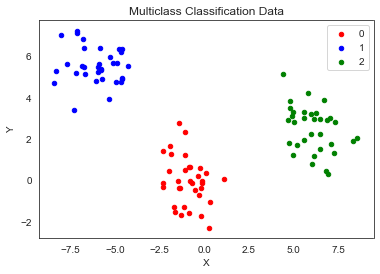

In [55]:
from matplotlib import pyplot
from pandas import DataFrame

X, y = sklearn.datasets.make_blobs(n_samples=100, centers=3, n_features=2)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
ax.set(title='Multiclass Classification Data', xlabel='X', ylabel='Y');
pyplot.show()

In [28]:
X = scale(X)
X = X.astype(floatX)
y = y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.5)

In [29]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        
        ann_input = pm.Data('ann_input', X_train)
        ann_output = pm.Data('ann_output', Y_train)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Multiclass classification -> Categorical
        out = pm.Categorical('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] 
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

In [50]:
pred = sample_proba(X_test, 500).mean(0) > 0.5
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 48.0%


Average Loss = 187.84: 100%|███████████████████████████████████████████████████| 40000/40000 [00:31<00:00, 1289.07it/s]
Finished [100%]: Average Loss = 187.8


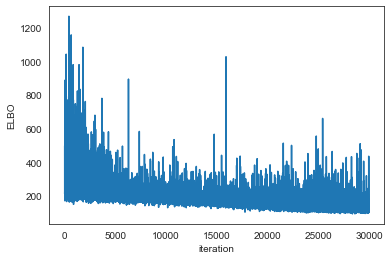

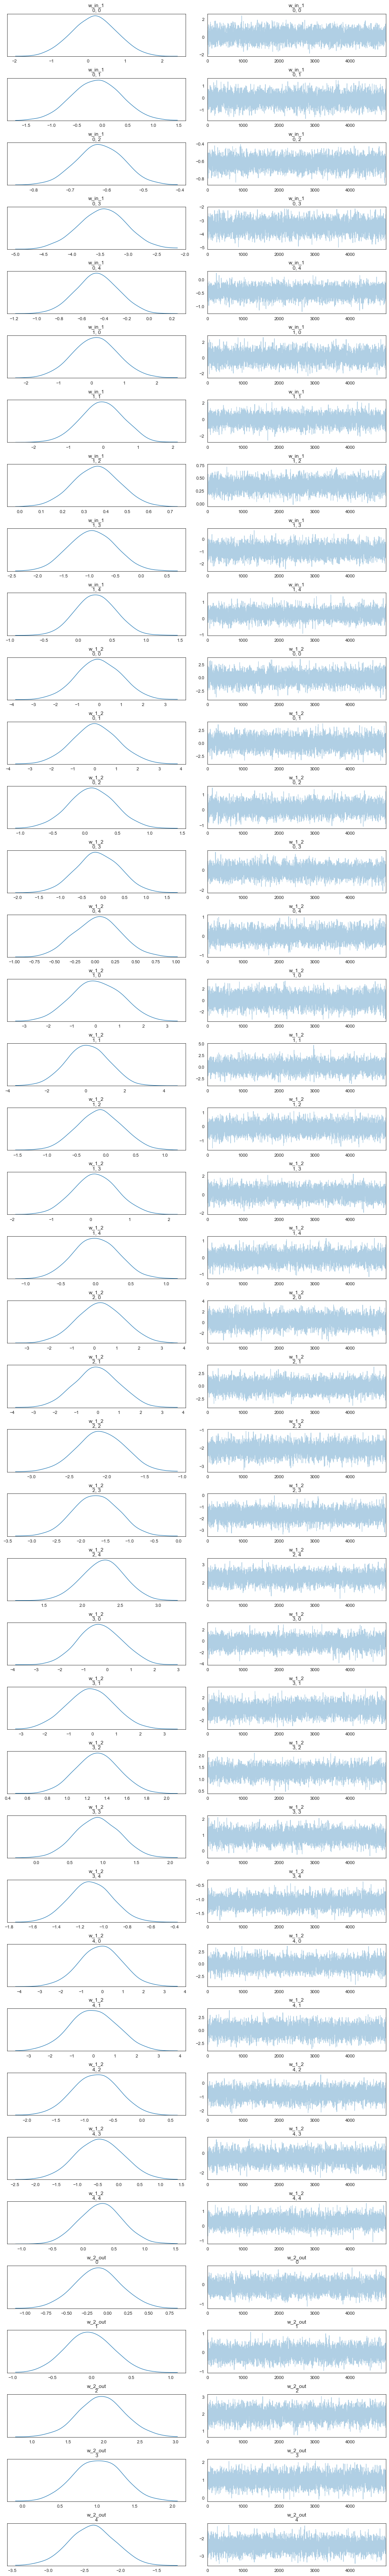

In [51]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    approx = pm.fit(40000, method=pm.ADVI())
plt.plot(inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');
pm.traceplot(trace);

In [52]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=4000)

Epoch 1/4000
50/50 [==============================] - ETA: 0s - loss: -24.0109 - accuracy: 0.53 - 0s 9ms/step - loss: -18.4407 - accuracy: 0.6400
Epoch 2/4000
50/50 [==============================] - ETA: 0s - loss: -17.6116 - accuracy: 0.65 - 0s 260us/step - loss: -18.4449 - accuracy: 0.6400
Epoch 3/4000
50/50 [==============================] - ETA: 0s - loss: -16.0139 - accuracy: 0.68 - 0s 160us/step - loss: -18.4490 - accuracy: 0.6400
Epoch 4/4000
50/50 [==============================] - ETA: 0s - loss: -9.6105 - accuracy: 0.812 - 0s 220us/step - loss: -18.4535 - accuracy: 0.6400
Epoch 5/4000
50/50 [==============================] - ETA: 0s - loss: -19.2253 - accuracy: 0.62 - 0s 160us/step - loss: -18.4570 - accuracy: 0.6400
Epoch 6/4000
50/50 [==============================] - ETA: 0s - loss: -19.2296 - accuracy: 0.62 - 0s 200us/step - loss: -18.4611 - accuracy: 0.6400
Epoch 7/4000
50/50 [==============================] - ETA: 0s - loss: -17.6311 - accuracy: 0.65 - 0s 180us/step - 

Epoch 56/4000
50/50 [==============================] - ETA: 0s - loss: -19.4470 - accuracy: 0.62 - 0s 180us/step - loss: -18.6698 - accuracy: 0.6400
Epoch 57/4000
50/50 [==============================] - ETA: 0s - loss: -17.8305 - accuracy: 0.65 - 0s 260us/step - loss: -18.6742 - accuracy: 0.6400
Epoch 58/4000
50/50 [==============================] - ETA: 0s - loss: -21.0772 - accuracy: 0.59 - 0s 220us/step - loss: -18.6782 - accuracy: 0.6400
Epoch 59/4000
50/50 [==============================] - ETA: 0s - loss: -19.4602 - accuracy: 0.62 - 0s 180us/step - loss: -18.6825 - accuracy: 0.6400
Epoch 60/4000
50/50 [==============================] - ETA: 0s - loss: -19.4646 - accuracy: 0.62 - 0s 200us/step - loss: -18.6867 - accuracy: 0.6400
Epoch 61/4000
50/50 [==============================] - ETA: 0s - loss: -21.0914 - accuracy: 0.59 - 0s 200us/step - loss: -18.6908 - accuracy: 0.6400
Epoch 62/4000
50/50 [==============================] - ETA: 0s - loss: -17.8505 - accuracy: 0.65 - 0s 200u

Epoch 111/4000
50/50 [==============================] - ETA: 0s - loss: -14.7671 - accuracy: 0.71 - 0s 180us/step - loss: -18.9029 - accuracy: 0.6400
Epoch 112/4000
50/50 [==============================] - ETA: 0s - loss: -16.4115 - accuracy: 0.68 - 0s 200us/step - loss: -18.9070 - accuracy: 0.6400
Epoch 113/4000
50/50 [==============================] - ETA: 0s - loss: -18.0568 - accuracy: 0.65 - 0s 160us/step - loss: -18.9112 - accuracy: 0.6400
Epoch 114/4000
50/50 [==============================] - ETA: 0s - loss: -22.9866 - accuracy: 0.56 - 0s 180us/step - loss: -18.9152 - accuracy: 0.6400
Epoch 115/4000
50/50 [==============================] - ETA: 0s - loss: -16.4227 - accuracy: 0.68 - 0s 160us/step - loss: -18.9199 - accuracy: 0.6400
Epoch 116/4000
50/50 [==============================] - ETA: 0s - loss: -14.7837 - accuracy: 0.71 - 0s 220us/step - loss: -18.9242 - accuracy: 0.6400
Epoch 117/4000
50/50 [==============================] - ETA: 0s - loss: -18.0731 - accuracy: 0.65 - 

50/50 [==============================] - ETA: 0s - loss: -26.5714 - accuracy: 0.50 - 0s 180us/step - loss: -19.1317 - accuracy: 0.6400
Epoch 166/4000
50/50 [==============================] - ETA: 0s - loss: -16.6108 - accuracy: 0.68 - 0s 240us/step - loss: -19.1366 - accuracy: 0.6400
Epoch 167/4000
50/50 [==============================] - ETA: 0s - loss: -19.9373 - accuracy: 0.62 - 0s 200us/step - loss: -19.1405 - accuracy: 0.6400
Epoch 168/4000
50/50 [==============================] - ETA: 0s - loss: -18.2798 - accuracy: 0.65 - 0s 220us/step - loss: -19.1448 - accuracy: 0.6400
Epoch 169/4000
50/50 [==============================] - ETA: 0s - loss: -21.6081 - accuracy: 0.59 - 0s 180us/step - loss: -19.1487 - accuracy: 0.6400
Epoch 170/4000
50/50 [==============================] - ETA: 0s - loss: -19.9503 - accuracy: 0.62 - 0s 220us/step - loss: -19.1530 - accuracy: 0.6400
Epoch 171/4000
50/50 [==============================] - ETA: 0s - loss: -19.9546 - accuracy: 0.62 - 0s 180us/step -

Epoch 220/4000
50/50 [==============================] - ETA: 0s - loss: -18.4875 - accuracy: 0.65 - 0s 200us/step - loss: -19.3623 - accuracy: 0.6400
Epoch 221/4000
50/50 [==============================] - ETA: 0s - loss: -18.4916 - accuracy: 0.65 - 0s 160us/step - loss: -19.3666 - accuracy: 0.6400
Epoch 222/4000
50/50 [==============================] - ETA: 0s - loss: -18.4957 - accuracy: 0.65 - 0s 160us/step - loss: -19.3709 - accuracy: 0.6400
Epoch 223/4000
50/50 [==============================] - ETA: 0s - loss: -23.5453 - accuracy: 0.56 - 0s 200us/step - loss: -19.3749 - accuracy: 0.6400
Epoch 224/4000
50/50 [==============================] - ETA: 0s - loss: -18.5040 - accuracy: 0.65 - 0s 200us/step - loss: -19.3795 - accuracy: 0.6400
Epoch 225/4000
50/50 [==============================] - ETA: 0s - loss: -20.1905 - accuracy: 0.62 - 0s 200us/step - loss: -19.3836 - accuracy: 0.6400
Epoch 226/4000
50/50 [==============================] - ETA: 0s - loss: -18.5120 - accuracy: 0.65 - 

50/50 [==============================] - ETA: 0s - loss: -20.4042 - accuracy: 0.62 - 0s 220us/step - loss: -19.5888 - accuracy: 0.6400
Epoch 275/4000
50/50 [==============================] - ETA: 0s - loss: -20.4086 - accuracy: 0.62 - 0s 200us/step - loss: -19.5929 - accuracy: 0.6400
Epoch 276/4000
50/50 [==============================] - ETA: 0s - loss: -18.7118 - accuracy: 0.65 - 0s 180us/step - loss: -19.5972 - accuracy: 0.6400
Epoch 277/4000
50/50 [==============================] - ETA: 0s - loss: -17.0144 - accuracy: 0.68 - 0s 160us/step - loss: -19.6015 - accuracy: 0.6400
Epoch 278/4000
50/50 [==============================] - ETA: 0s - loss: -20.4216 - accuracy: 0.62 - 0s 180us/step - loss: -19.6055 - accuracy: 0.6400
Epoch 279/4000
50/50 [==============================] - ETA: 0s - loss: -15.3195 - accuracy: 0.71 - 0s 340us/step - loss: -19.6100 - accuracy: 0.6400
Epoch 280/4000
50/50 [==============================] - ETA: 0s - loss: -11.9177 - accuracy: 0.78 - 0s 180us/step -

Epoch 329/4000
50/50 [==============================] - ETA: 0s - loss: -22.3692 - accuracy: 0.59 - 0s 200us/step - loss: -19.8231 - accuracy: 0.6400
Epoch 330/4000
50/50 [==============================] - ETA: 0s - loss: -20.6528 - accuracy: 0.62 - 0s 160us/step - loss: -19.8274 - accuracy: 0.6400
Epoch 331/4000
50/50 [==============================] - ETA: 0s - loss: -18.9357 - accuracy: 0.65 - 0s 200us/step - loss: -19.8316 - accuracy: 0.6400
Epoch 332/4000
50/50 [==============================] - ETA: 0s - loss: -15.4961 - accuracy: 0.71 - 0s 180us/step - loss: -19.8360 - accuracy: 0.6400
Epoch 333/4000
50/50 [==============================] - ETA: 0s - loss: -24.1100 - accuracy: 0.56 - 0s 200us/step - loss: -19.8396 - accuracy: 0.6400
Epoch 334/4000
50/50 [==============================] - ETA: 0s - loss: -22.3927 - accuracy: 0.59 - 0s 200us/step - loss: -19.8439 - accuracy: 0.6400
Epoch 335/4000
50/50 [==============================] - ETA: 0s - loss: -22.3974 - accuracy: 0.59 - 

50/50 [==============================] - ETA: 0s - loss: -15.6624 - accuracy: 0.71 - 0s 180us/step - loss: -20.0490 - accuracy: 0.6400
Epoch 384/4000
50/50 [==============================] - ETA: 0s - loss: -17.4064 - accuracy: 0.68 - 0s 180us/step - loss: -20.0531 - accuracy: 0.6400
Epoch 385/4000
50/50 [==============================] - ETA: 0s - loss: -22.6332 - accuracy: 0.59 - 0s 180us/step - loss: -20.0571 - accuracy: 0.6400
Epoch 386/4000
50/50 [==============================] - ETA: 0s - loss: -19.1553 - accuracy: 0.65 - 0s 200us/step - loss: -20.0616 - accuracy: 0.6400
Epoch 387/4000
50/50 [==============================] - ETA: 0s - loss: -15.6759 - accuracy: 0.71 - 0s 180us/step - loss: -20.0661 - accuracy: 0.6400
Epoch 388/4000
50/50 [==============================] - ETA: 0s - loss: -20.9056 - accuracy: 0.62 - 0s 180us/step - loss: -20.0701 - accuracy: 0.6400
Epoch 389/4000
50/50 [==============================] - ETA: 0s - loss: -17.4251 - accuracy: 0.68 - 0s 180us/step -

Epoch 438/4000
50/50 [==============================] - ETA: 0s - loss: -17.6061 - accuracy: 0.68 - 0s 180us/step - loss: -20.2831 - accuracy: 0.6400
Epoch 439/4000
50/50 [==============================] - ETA: 0s - loss: -21.1317 - accuracy: 0.62 - 0s 160us/step - loss: -20.2872 - accuracy: 0.6400
Epoch 440/4000
50/50 [==============================] - ETA: 0s - loss: -15.8522 - accuracy: 0.71 - 0s 180us/step - loss: -20.2918 - accuracy: 0.6400
Epoch 441/4000
50/50 [==============================] - ETA: 0s - loss: -17.6172 - accuracy: 0.68 - 0s 180us/step - loss: -20.2960 - accuracy: 0.6400
Epoch 442/4000
50/50 [==============================] - ETA: 0s - loss: -21.1452 - accuracy: 0.62 - 0s 160us/step - loss: -20.3001 - accuracy: 0.6400
Epoch 443/4000
50/50 [==============================] - ETA: 0s - loss: -15.8623 - accuracy: 0.71 - 0s 140us/step - loss: -20.3048 - accuracy: 0.6400
Epoch 444/4000
50/50 [==============================] - ETA: 0s - loss: -21.1542 - accuracy: 0.62 - 

50/50 [==============================] - ETA: 0s - loss: -23.1475 - accuracy: 0.59 - 0s 180us/step - loss: -20.5128 - accuracy: 0.6400
Epoch 493/4000
50/50 [==============================] - ETA: 0s - loss: -23.1522 - accuracy: 0.59 - 0s 200us/step - loss: -20.5170 - accuracy: 0.6400
Epoch 494/4000
50/50 [==============================] - ETA: 0s - loss: -23.1569 - accuracy: 0.59 - 0s 220us/step - loss: -20.5212 - accuracy: 0.6400
Epoch 495/4000
50/50 [==============================] - ETA: 0s - loss: -23.1616 - accuracy: 0.59 - 0s 220us/step - loss: -20.5253 - accuracy: 0.6400
Epoch 496/4000
50/50 [==============================] - ETA: 0s - loss: -19.6022 - accuracy: 0.65 - 0s 200us/step - loss: -20.5296 - accuracy: 0.6400
Epoch 497/4000
50/50 [==============================] - ETA: 0s - loss: -14.2590 - accuracy: 0.75 - 0s 200us/step - loss: -20.5340 - accuracy: 0.6400
Epoch 498/4000
50/50 [==============================] - ETA: 0s - loss: -17.8273 - accuracy: 0.68 - 0s 160us/step -

Epoch 547/4000
50/50 [==============================] - ETA: 0s - loss: -23.4095 - accuracy: 0.59 - 0s 160us/step - loss: -20.7451 - accuracy: 0.6400
Epoch 548/4000
50/50 [==============================] - ETA: 0s - loss: -19.8121 - accuracy: 0.65 - 0s 200us/step - loss: -20.7495 - accuracy: 0.6400
Epoch 549/4000
50/50 [==============================] - ETA: 0s - loss: -14.4117 - accuracy: 0.75 - 0s 180us/step - loss: -20.7540 - accuracy: 0.6400
Epoch 550/4000
50/50 [==============================] - ETA: 0s - loss: -21.6219 - accuracy: 0.62 - 0s 560us/step - loss: -20.7578 - accuracy: 0.6400
Epoch 551/4000
50/50 [==============================] - ETA: 0s - loss: -19.8242 - accuracy: 0.65 - 0s 160us/step - loss: -20.7622 - accuracy: 0.6400
Epoch 552/4000
50/50 [==============================] - ETA: 0s - loss: -18.0257 - accuracy: 0.68 - 0s 200us/step - loss: -20.7666 - accuracy: 0.6400
Epoch 553/4000
50/50 [==============================] - ETA: 0s - loss: -23.4382 - accuracy: 0.59 - 

50/50 [==============================] - ETA: 0s - loss: -20.0271 - accuracy: 0.65 - 0s 200us/step - loss: -20.9746 - accuracy: 0.6400
Epoch 602/4000
50/50 [==============================] - ETA: 0s - loss: -18.2101 - accuracy: 0.68 - 0s 240us/step - loss: -20.9789 - accuracy: 0.6400
Epoch 603/4000
50/50 [==============================] - ETA: 0s - loss: -25.4992 - accuracy: 0.56 - 0s 200us/step - loss: -20.9827 - accuracy: 0.6400
Epoch 604/4000
50/50 [==============================] - ETA: 0s - loss: -20.0392 - accuracy: 0.65 - 0s 160us/step - loss: -20.9873 - accuracy: 0.6400
Epoch 605/4000
50/50 [==============================] - ETA: 0s - loss: -21.8652 - accuracy: 0.62 - 0s 160us/step - loss: -20.9913 - accuracy: 0.6400
Epoch 606/4000
50/50 [==============================] - ETA: 0s - loss: -20.0472 - accuracy: 0.65 - 0s 200us/step - loss: -20.9957 - accuracy: 0.6400
Epoch 607/4000
50/50 [==============================] - ETA: 0s - loss: -27.3425 - accuracy: 0.53 - 0s 180us/step -

Epoch 656/4000
50/50 [==============================] - ETA: 0s - loss: -14.7240 - accuracy: 0.75 - 0s 200us/step - loss: -21.2037 - accuracy: 0.6400
Epoch 657/4000
50/50 [==============================] - ETA: 0s - loss: -22.0904 - accuracy: 0.62 - 0s 200us/step - loss: -21.2075 - accuracy: 0.6400
Epoch 658/4000
50/50 [==============================] - ETA: 0s - loss: -18.4124 - accuracy: 0.68 - 0s 180us/step - loss: -21.2120 - accuracy: 0.6400
Epoch 659/4000
50/50 [==============================] - ETA: 0s - loss: -23.9409 - accuracy: 0.59 - 0s 180us/step - loss: -21.2160 - accuracy: 0.6400
Epoch 660/4000
50/50 [==============================] - ETA: 0s - loss: -23.9458 - accuracy: 0.59 - 0s 180us/step - loss: -21.2203 - accuracy: 0.6400
Epoch 661/4000
50/50 [==============================] - ETA: 0s - loss: -22.1083 - accuracy: 0.62 - 0s 200us/step - loss: -21.2246 - accuracy: 0.6400
Epoch 662/4000
50/50 [==============================] - ETA: 0s - loss: -22.1127 - accuracy: 0.62 - 

50/50 [==============================] - ETA: 0s - loss: -22.3244 - accuracy: 0.62 - 0s 180us/step - loss: -21.4321 - accuracy: 0.6400
Epoch 711/4000
50/50 [==============================] - ETA: 0s - loss: -26.0504 - accuracy: 0.56 - 0s 180us/step - loss: -21.4363 - accuracy: 0.6400
Epoch 712/4000
50/50 [==============================] - ETA: 0s - loss: -22.3335 - accuracy: 0.62 - 0s 220us/step - loss: -21.4409 - accuracy: 0.6400
Epoch 713/4000
50/50 [==============================] - ETA: 0s - loss: -22.3379 - accuracy: 0.62 - 0s 220us/step - loss: -21.4451 - accuracy: 0.6400
Epoch 714/4000
50/50 [==============================] - ETA: 0s - loss: -20.4805 - accuracy: 0.65 - 0s 160us/step - loss: -21.4495 - accuracy: 0.6400
Epoch 715/4000
50/50 [==============================] - ETA: 0s - loss: -16.7601 - accuracy: 0.71 - 0s 160us/step - loss: -21.4539 - accuracy: 0.6400
Epoch 716/4000
50/50 [==============================] - ETA: 0s - loss: -16.7634 - accuracy: 0.71 - 0s 200us/step -

Epoch 765/4000
50/50 [==============================] - ETA: 0s - loss: -20.6875 - accuracy: 0.65 - 0s 180us/step - loss: -21.6662 - accuracy: 0.6400
Epoch 766/4000
50/50 [==============================] - ETA: 0s - loss: -22.5725 - accuracy: 0.62 - 0s 140us/step - loss: -21.6704 - accuracy: 0.6400
Epoch 767/4000
50/50 [==============================] - ETA: 0s - loss: -24.4584 - accuracy: 0.59 - 0s 260us/step - loss: -21.6745 - accuracy: 0.6400
Epoch 768/4000
50/50 [==============================] - ETA: 0s - loss: -24.4632 - accuracy: 0.59 - 0s 240us/step - loss: -21.6787 - accuracy: 0.6400
Epoch 769/4000
50/50 [==============================] - ETA: 0s - loss: -22.5857 - accuracy: 0.62 - 0s 220us/step - loss: -21.6830 - accuracy: 0.6400
Epoch 770/4000
50/50 [==============================] - ETA: 0s - loss: -22.5901 - accuracy: 0.62 - 0s 220us/step - loss: -21.6872 - accuracy: 0.6400
Epoch 771/4000
50/50 [==============================] - ETA: 0s - loss: -22.5944 - accuracy: 0.62 - 

50/50 [==============================] - ETA: 0s - loss: -24.7051 - accuracy: 0.59 - 0s 160us/step - loss: -21.8932 - accuracy: 0.6400
Epoch 820/4000
50/50 [==============================] - ETA: 0s - loss: -22.8092 - accuracy: 0.62 - 0s 240us/step - loss: -21.8975 - accuracy: 0.6400
Epoch 821/4000
50/50 [==============================] - ETA: 0s - loss: -15.2090 - accuracy: 0.75 - 0s 260us/step - loss: -21.9021 - accuracy: 0.6400
Epoch 822/4000
50/50 [==============================] - ETA: 0s - loss: -20.9164 - accuracy: 0.65 - 0s 240us/step - loss: -21.9060 - accuracy: 0.6400
Epoch 823/4000
50/50 [==============================] - ETA: 0s - loss: -26.6260 - accuracy: 0.56 - 0s 200us/step - loss: -21.9099 - accuracy: 0.6400
Epoch 824/4000
50/50 [==============================] - ETA: 0s - loss: -20.9246 - accuracy: 0.65 - 0s 200us/step - loss: -21.9145 - accuracy: 0.6400
Epoch 825/4000
50/50 [==============================] - ETA: 0s - loss: -24.7338 - accuracy: 0.59 - 0s 220us/step -

Epoch 874/4000
50/50 [==============================] - ETA: 0s - loss: -17.2853 - accuracy: 0.71 - 0s 180us/step - loss: -22.1262 - accuracy: 0.6400
Epoch 875/4000
50/50 [==============================] - ETA: 0s - loss: -23.0515 - accuracy: 0.62 - 0s 180us/step - loss: -22.1302 - accuracy: 0.6400
Epoch 876/4000
50/50 [==============================] - ETA: 0s - loss: -24.9773 - accuracy: 0.59 - 0s 180us/step - loss: -22.1344 - accuracy: 0.6400
Epoch 877/4000
50/50 [==============================] - ETA: 0s - loss: -17.2954 - accuracy: 0.71 - 0s 220us/step - loss: -22.1391 - accuracy: 0.6400
Epoch 878/4000
50/50 [==============================] - ETA: 0s - loss: -21.1428 - accuracy: 0.65 - 0s 200us/step - loss: -22.1431 - accuracy: 0.6400
Epoch 879/4000
50/50 [==============================] - ETA: 0s - loss: -28.8367 - accuracy: 0.53 - 0s 140us/step - loss: -22.1470 - accuracy: 0.6400
Epoch 880/4000
50/50 [==============================] - ETA: 0s - loss: -21.1510 - accuracy: 0.65 - 

50/50 [==============================] - ETA: 0s - loss: -23.2834 - accuracy: 0.62 - 0s 240us/step - loss: -22.3527 - accuracy: 0.6400
Epoch 929/4000
50/50 [==============================] - ETA: 0s - loss: -19.4064 - accuracy: 0.68 - 0s 200us/step - loss: -22.3571 - accuracy: 0.6400
Epoch 930/4000
50/50 [==============================] - ETA: 0s - loss: -17.4690 - accuracy: 0.71 - 0s 200us/step - loss: -22.3614 - accuracy: 0.6400
Epoch 931/4000
50/50 [==============================] - ETA: 0s - loss: -19.4137 - accuracy: 0.68 - 0s 180us/step - loss: -22.3655 - accuracy: 0.6400
Epoch 932/4000
50/50 [==============================] - ETA: 0s - loss: -23.3008 - accuracy: 0.62 - 0s 200us/step - loss: -22.3695 - accuracy: 0.6400
Epoch 933/4000
50/50 [==============================] - ETA: 0s - loss: -19.4211 - accuracy: 0.68 - 0s 220us/step - loss: -22.3741 - accuracy: 0.6400
Epoch 934/4000
50/50 [==============================] - ETA: 0s - loss: -19.4248 - accuracy: 0.68 - 0s 200us/step -

Epoch 983/4000
50/50 [==============================] - ETA: 0s - loss: -17.6460 - accuracy: 0.71 - 0s 180us/step - loss: -22.5879 - accuracy: 0.6400
Epoch 984/4000
50/50 [==============================] - ETA: 0s - loss: -25.4934 - accuracy: 0.59 - 0s 180us/step - loss: -22.5917 - accuracy: 0.6400
Epoch 985/4000
50/50 [==============================] - ETA: 0s - loss: -17.6526 - accuracy: 0.71 - 0s 220us/step - loss: -22.5964 - accuracy: 0.6400
Epoch 986/4000
50/50 [==============================] - ETA: 0s - loss: -23.5412 - accuracy: 0.62 - 0s 160us/step - loss: -22.6002 - accuracy: 0.6400
Epoch 987/4000
50/50 [==============================] - ETA: 0s - loss: -25.5078 - accuracy: 0.59 - 0s 180us/step - loss: -22.6044 - accuracy: 0.6400
Epoch 988/4000
50/50 [==============================] - ETA: 0s - loss: -23.5501 - accuracy: 0.62 - 0s 180us/step - loss: -22.6088 - accuracy: 0.6400
Epoch 989/4000
50/50 [==============================] - ETA: 0s - loss: -23.5545 - accuracy: 0.62 - 

50/50 [==============================] - ETA: 0s - loss: -23.7661 - accuracy: 0.62 - 0s 160us/step - loss: -22.8161 - accuracy: 0.6400
Epoch 1038/4000
50/50 [==============================] - ETA: 0s - loss: -25.7513 - accuracy: 0.59 - 0s 180us/step - loss: -22.8202 - accuracy: 0.6400
Epoch 1039/4000
50/50 [==============================] - ETA: 0s - loss: -23.7748 - accuracy: 0.62 - 0s 180us/step - loss: -22.8245 - accuracy: 0.6400
Epoch 1040/4000
50/50 [==============================] - ETA: 0s - loss: -17.8344 - accuracy: 0.71 - 0s 180us/step - loss: -22.8290 - accuracy: 0.6400
Epoch 1041/4000
50/50 [==============================] - ETA: 0s - loss: -23.7835 - accuracy: 0.62 - 0s 180us/step - loss: -22.8329 - accuracy: 0.6400
Epoch 1042/4000
50/50 [==============================] - ETA: 0s - loss: -15.8586 - accuracy: 0.75 - 0s 200us/step - loss: -22.8376 - accuracy: 0.6400
Epoch 1043/4000
50/50 [==============================] - ETA: 0s - loss: -19.8269 - accuracy: 0.68 - 0s 220us/

50/50 [==============================] - ETA: 0s - loss: -30.0074 - accuracy: 0.53 - 0s 220us/step - loss: -23.0461 - accuracy: 0.6400
Epoch 1092/4000
50/50 [==============================] - ETA: 0s - loss: -24.0105 - accuracy: 0.62 - 0s 220us/step - loss: -23.0508 - accuracy: 0.6400
Epoch 1093/4000
50/50 [==============================] - ETA: 0s - loss: -20.0124 - accuracy: 0.68 - 0s 180us/step - loss: -23.0552 - accuracy: 0.6400
Epoch 1094/4000
50/50 [==============================] - ETA: 0s - loss: -22.0176 - accuracy: 0.65 - 0s 180us/step - loss: -23.0593 - accuracy: 0.6400
Epoch 1095/4000
50/50 [==============================] - ETA: 0s - loss: -26.0256 - accuracy: 0.59 - 0s 220us/step - loss: -23.0633 - accuracy: 0.6400
Epoch 1096/4000
50/50 [==============================] - ETA: 0s - loss: -24.0281 - accuracy: 0.62 - 0s 180us/step - loss: -23.0677 - accuracy: 0.6400
Epoch 1097/4000
50/50 [==============================] - ETA: 0s - loss: -26.0352 - accuracy: 0.59 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -20.2040 - accuracy: 0.68 - 0s 200us/step - loss: -23.2759 - accuracy: 0.6400
Epoch 1146/4000
50/50 [==============================] - ETA: 0s - loss: -26.2699 - accuracy: 0.59 - 0s 200us/step - loss: -23.2798 - accuracy: 0.6400
Epoch 1147/4000
50/50 [==============================] - ETA: 0s - loss: -20.2113 - accuracy: 0.68 - 0s 160us/step - loss: -23.2843 - accuracy: 0.6400
Epoch 1148/4000
50/50 [==============================] - ETA: 0s - loss: -28.3009 - accuracy: 0.56 - 0s 180us/step - loss: -23.2881 - accuracy: 0.6400
Epoch 1149/4000
50/50 [==============================] - ETA: 0s - loss: -26.2842 - accuracy: 0.59 - 0s 180us/step - loss: -23.2924 - accuracy: 0.6400
Epoch 1150/4000
50/50 [==============================] - ETA: 0s - loss: -22.2445 - accuracy: 0.65 - 0s 200us/step - loss: -23.2968 - accuracy: 0.6400
Epoch 1151/4000
50/50 [==============================] - ETA: 0s - loss: -22.2484 - accuracy: 0.65 - 0s 220us/

50/50 [==============================] - ETA: 0s - loss: -20.4014 - accuracy: 0.68 - 0s 200us/step - loss: -23.5033 - accuracy: 0.6400
Epoch 1200/4000
50/50 [==============================] - ETA: 0s - loss: -24.4861 - accuracy: 0.62 - 0s 220us/step - loss: -23.5074 - accuracy: 0.6400
Epoch 1201/4000
50/50 [==============================] - ETA: 0s - loss: -26.5315 - accuracy: 0.59 - 0s 220us/step - loss: -23.5116 - accuracy: 0.6400
Epoch 1202/4000
50/50 [==============================] - ETA: 0s - loss: -24.4951 - accuracy: 0.62 - 0s 240us/step - loss: -23.5161 - accuracy: 0.6400
Epoch 1203/4000
50/50 [==============================] - ETA: 0s - loss: -22.4579 - accuracy: 0.65 - 0s 220us/step - loss: -23.5204 - accuracy: 0.6400
Epoch 1204/4000
50/50 [==============================] - ETA: 0s - loss: -22.4620 - accuracy: 0.65 - 0s 220us/step - loss: -23.5247 - accuracy: 0.6400
Epoch 1205/4000
50/50 [==============================] - ETA: 0s - loss: -28.5932 - accuracy: 0.56 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -24.7210 - accuracy: 0.62 - 0s 180us/step - loss: -23.7329 - accuracy: 0.6400
Epoch 1254/4000
50/50 [==============================] - ETA: 0s - loss: -22.6650 - accuracy: 0.65 - 0s 202us/step - loss: -23.7372 - accuracy: 0.6400
Epoch 1255/4000
50/50 [==============================] - ETA: 0s - loss: -26.7906 - accuracy: 0.59 - 0s 180us/step - loss: -23.7412 - accuracy: 0.6400
Epoch 1256/4000
50/50 [==============================] - ETA: 0s - loss: -24.7342 - accuracy: 0.62 - 0s 200us/step - loss: -23.7456 - accuracy: 0.6400
Epoch 1257/4000
50/50 [==============================] - ETA: 0s - loss: -22.6770 - accuracy: 0.65 - 0s 220us/step - loss: -23.7498 - accuracy: 0.6400
Epoch 1258/4000
50/50 [==============================] - ETA: 0s - loss: -30.9287 - accuracy: 0.53 - 0s 260us/step - loss: -23.7536 - accuracy: 0.6400
Epoch 1259/4000
50/50 [==============================] - ETA: 0s - loss: -24.7473 - accuracy: 0.62 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -22.8781 - accuracy: 0.65 - 0s 220us/step - loss: -23.9604 - accuracy: 0.6400
Epoch 1308/4000
50/50 [==============================] - ETA: 0s - loss: -27.0426 - accuracy: 0.59 - 0s 160us/step - loss: -23.9645 - accuracy: 0.6400
Epoch 1309/4000
50/50 [==============================] - ETA: 0s - loss: -24.9668 - accuracy: 0.62 - 0s 180us/step - loss: -23.9689 - accuracy: 0.6400
Epoch 1310/4000
50/50 [==============================] - ETA: 0s - loss: -27.0522 - accuracy: 0.59 - 0s 200us/step - loss: -23.9730 - accuracy: 0.6400
Epoch 1311/4000
50/50 [==============================] - ETA: 0s - loss: -27.0569 - accuracy: 0.59 - 0s 140us/step - loss: -23.9772 - accuracy: 0.6400
Epoch 1312/4000
50/50 [==============================] - ETA: 0s - loss: -27.0616 - accuracy: 0.59 - 0s 180us/step - loss: -23.9814 - accuracy: 0.6400
Epoch 1313/4000
50/50 [==============================] - ETA: 0s - loss: -31.2304 - accuracy: 0.53 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -20.9948 - accuracy: 0.68 - 0s 200us/step - loss: -24.1870 - accuracy: 0.6400
Epoch 1362/4000
50/50 [==============================] - ETA: 0s - loss: -25.1982 - accuracy: 0.62 - 0s 180us/step - loss: -24.1910 - accuracy: 0.6400
Epoch 1363/4000
50/50 [==============================] - ETA: 0s - loss: -23.1024 - accuracy: 0.65 - 0s 180us/step - loss: -24.1953 - accuracy: 0.6400
Epoch 1364/4000
50/50 [==============================] - ETA: 0s - loss: -16.8047 - accuracy: 0.75 - 0s 200us/step - loss: -24.1999 - accuracy: 0.6400
Epoch 1365/4000
50/50 [==============================] - ETA: 0s - loss: -29.4133 - accuracy: 0.56 - 0s 180us/step - loss: -24.2035 - accuracy: 0.6400
Epoch 1366/4000
50/50 [==============================] - ETA: 0s - loss: -23.1146 - accuracy: 0.65 - 0s 200us/step - loss: -24.2081 - accuracy: 0.6400
Epoch 1367/4000
50/50 [==============================] - ETA: 0s - loss: -23.1187 - accuracy: 0.65 - 0s 240us/

50/50 [==============================] - ETA: 0s - loss: -27.5541 - accuracy: 0.59 - 0s 200us/step - loss: -24.4177 - accuracy: 0.6400
Epoch 1416/4000
50/50 [==============================] - ETA: 0s - loss: -23.3190 - accuracy: 0.65 - 0s 240us/step - loss: -24.4222 - accuracy: 0.6400
Epoch 1417/4000
50/50 [==============================] - ETA: 0s - loss: -31.8041 - accuracy: 0.53 - 0s 220us/step - loss: -24.4259 - accuracy: 0.6400
Epoch 1418/4000
50/50 [==============================] - ETA: 0s - loss: -21.2064 - accuracy: 0.68 - 0s 540us/step - loss: -24.4306 - accuracy: 0.6400
Epoch 1419/4000
50/50 [==============================] - ETA: 0s - loss: -14.8470 - accuracy: 0.78 - 0s 160us/step - loss: -24.4351 - accuracy: 0.6400
Epoch 1420/4000
50/50 [==============================] - ETA: 0s - loss: -25.4563 - accuracy: 0.62 - 0s 160us/step - loss: -24.4387 - accuracy: 0.6400
Epoch 1421/4000
50/50 [==============================] - ETA: 0s - loss: -27.5825 - accuracy: 0.59 - 0s 220us/

50/50 [==============================] - ETA: 0s - loss: -21.3929 - accuracy: 0.68 - 0s 160us/step - loss: -24.6456 - accuracy: 0.6400
Epoch 1470/4000
50/50 [==============================] - ETA: 0s - loss: -25.6758 - accuracy: 0.62 - 0s 140us/step - loss: -24.6495 - accuracy: 0.6400
Epoch 1471/4000
50/50 [==============================] - ETA: 0s - loss: -27.8202 - accuracy: 0.59 - 0s 240us/step - loss: -24.6536 - accuracy: 0.6400
Epoch 1472/4000
50/50 [==============================] - ETA: 0s - loss: -27.8250 - accuracy: 0.59 - 0s 200us/step - loss: -24.6578 - accuracy: 0.6400
Epoch 1473/4000
50/50 [==============================] - ETA: 0s - loss: -23.5482 - accuracy: 0.65 - 0s 140us/step - loss: -24.6622 - accuracy: 0.6400
Epoch 1474/4000
50/50 [==============================] - ETA: 0s - loss: -23.5521 - accuracy: 0.65 - 0s 180us/step - loss: -24.6663 - accuracy: 0.6400
Epoch 1475/4000
50/50 [==============================] - ETA: 0s - loss: -21.4146 - accuracy: 0.68 - 0s 160us/

50/50 [==============================] - ETA: 0s - loss: -19.4318 - accuracy: 0.71 - 0s 200us/step - loss: -24.8738 - accuracy: 0.6400
Epoch 1524/4000
50/50 [==============================] - ETA: 0s - loss: -19.4351 - accuracy: 0.71 - 0s 200us/step - loss: -24.8780 - accuracy: 0.6400
Epoch 1525/4000
50/50 [==============================] - ETA: 0s - loss: -25.9180 - accuracy: 0.62 - 0s 160us/step - loss: -24.8820 - accuracy: 0.6400
Epoch 1526/4000
50/50 [==============================] - ETA: 0s - loss: -28.0828 - accuracy: 0.59 - 0s 220us/step - loss: -24.8862 - accuracy: 0.6400
Epoch 1527/4000
50/50 [==============================] - ETA: 0s - loss: -25.9270 - accuracy: 0.62 - 0s 220us/step - loss: -24.8907 - accuracy: 0.6400
Epoch 1528/4000
50/50 [==============================] - ETA: 0s - loss: -28.0925 - accuracy: 0.59 - 0s 200us/step - loss: -24.8948 - accuracy: 0.6400
Epoch 1529/4000
50/50 [==============================] - ETA: 0s - loss: -30.2586 - accuracy: 0.56 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -32.6823 - accuracy: 0.53 - 0s 260us/step - loss: -25.1004 - accuracy: 0.6400
Epoch 1578/4000
50/50 [==============================] - ETA: 0s - loss: -23.9710 - accuracy: 0.65 - 0s 200us/step - loss: -25.1049 - accuracy: 0.6400
Epoch 1579/4000
50/50 [==============================] - ETA: 0s - loss: -30.5134 - accuracy: 0.56 - 0s 160us/step - loss: -25.1087 - accuracy: 0.6400
Epoch 1580/4000
50/50 [==============================] - ETA: 0s - loss: -21.7989 - accuracy: 0.68 - 0s 200us/step - loss: -25.1132 - accuracy: 0.6400
Epoch 1581/4000
50/50 [==============================] - ETA: 0s - loss: -30.5233 - accuracy: 0.56 - 0s 200us/step - loss: -25.1168 - accuracy: 0.6400
Epoch 1582/4000
50/50 [==============================] - ETA: 0s - loss: -30.5284 - accuracy: 0.56 - 0s 220us/step - loss: -25.1209 - accuracy: 0.6400
Epoch 1583/4000
50/50 [==============================] - ETA: 0s - loss: -26.1714 - accuracy: 0.62 - 0s 240us/

50/50 [==============================] - ETA: 0s - loss: -30.7778 - accuracy: 0.56 - 0s 200us/step - loss: -25.3262 - accuracy: 0.6400
Epoch 1632/4000
50/50 [==============================] - ETA: 0s - loss: -21.9878 - accuracy: 0.68 - 0s 180us/step - loss: -25.3309 - accuracy: 0.6400
Epoch 1633/4000
50/50 [==============================] - ETA: 0s - loss: -26.3897 - accuracy: 0.62 - 0s 140us/step - loss: -25.3348 - accuracy: 0.6400
Epoch 1634/4000
50/50 [==============================] - ETA: 0s - loss: -30.7931 - accuracy: 0.56 - 0s 180us/step - loss: -25.3388 - accuracy: 0.6400
Epoch 1635/4000
50/50 [==============================] - ETA: 0s - loss: -26.3985 - accuracy: 0.62 - 0s 160us/step - loss: -25.3433 - accuracy: 0.6400
Epoch 1636/4000
50/50 [==============================] - ETA: 0s - loss: -26.4028 - accuracy: 0.62 - 0s 160us/step - loss: -25.3474 - accuracy: 0.6400
Epoch 1637/4000
50/50 [==============================] - ETA: 0s - loss: -22.0059 - accuracy: 0.68 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -28.8374 - accuracy: 0.59 - 0s 200us/step - loss: -25.5550 - accuracy: 0.6400
Epoch 1686/4000
50/50 [==============================] - ETA: 0s - loss: -26.6234 - accuracy: 0.62 - 0s 220us/step - loss: -25.5592 - accuracy: 0.6400
Epoch 1687/4000
50/50 [==============================] - ETA: 0s - loss: -26.6277 - accuracy: 0.62 - 0s 200us/step - loss: -25.5633 - accuracy: 0.6400
Epoch 1688/4000
50/50 [==============================] - ETA: 0s - loss: -26.6320 - accuracy: 0.62 - 0s 180us/step - loss: -25.5674 - accuracy: 0.6400
Epoch 1689/4000
50/50 [==============================] - ETA: 0s - loss: -26.6362 - accuracy: 0.62 - 0s 180us/step - loss: -25.5715 - accuracy: 0.6400
Epoch 1690/4000
50/50 [==============================] - ETA: 0s - loss: -26.6405 - accuracy: 0.62 - 0s 200us/step - loss: -25.5756 - accuracy: 0.6400
Epoch 1691/4000
50/50 [==============================] - ETA: 0s - loss: -22.2040 - accuracy: 0.68 - 0s 220us/

50/50 [==============================] - ETA: 0s - loss: -29.0924 - accuracy: 0.59 - 0s 200us/step - loss: -25.7810 - accuracy: 0.6400
Epoch 1740/4000
50/50 [==============================] - ETA: 0s - loss: -20.1442 - accuracy: 0.71 - 0s 200us/step - loss: -25.7856 - accuracy: 0.6400
Epoch 1741/4000
50/50 [==============================] - ETA: 0s - loss: -22.3860 - accuracy: 0.68 - 0s 200us/step - loss: -25.7897 - accuracy: 0.6400
Epoch 1742/4000
50/50 [==============================] - ETA: 0s - loss: -29.1066 - accuracy: 0.59 - 0s 220us/step - loss: -25.7936 - accuracy: 0.6400
Epoch 1743/4000
50/50 [==============================] - ETA: 0s - loss: -29.1115 - accuracy: 0.59 - 0s 200us/step - loss: -25.7978 - accuracy: 0.6400
Epoch 1744/4000
50/50 [==============================] - ETA: 0s - loss: -24.6368 - accuracy: 0.65 - 0s 220us/step - loss: -25.8023 - accuracy: 0.6400
Epoch 1745/4000
50/50 [==============================] - ETA: 0s - loss: -26.8809 - accuracy: 0.62 - 0s 200us/

50/50 [==============================] - ETA: 0s - loss: -24.8366 - accuracy: 0.65 - 0s 200us/step - loss: -26.0116 - accuracy: 0.6400
Epoch 1794/4000
50/50 [==============================] - ETA: 0s - loss: -24.8408 - accuracy: 0.65 - 0s 200us/step - loss: -26.0159 - accuracy: 0.6400
Epoch 1795/4000
50/50 [==============================] - ETA: 0s - loss: -31.6207 - accuracy: 0.56 - 0s 220us/step - loss: -26.0198 - accuracy: 0.6400
Epoch 1796/4000
50/50 [==============================] - ETA: 0s - loss: -29.3670 - accuracy: 0.59 - 0s 140us/step - loss: -26.0243 - accuracy: 0.6400
Epoch 1797/4000
50/50 [==============================] - ETA: 0s - loss: -29.3718 - accuracy: 0.59 - 0s 180us/step - loss: -26.0285 - accuracy: 0.6400
Epoch 1798/4000
50/50 [==============================] - ETA: 0s - loss: -29.3765 - accuracy: 0.59 - 0s 140us/step - loss: -26.0327 - accuracy: 0.6400
Epoch 1799/4000
50/50 [==============================] - ETA: 0s - loss: -24.8610 - accuracy: 0.65 - 0s 160us/

50/50 [==============================] - ETA: 0s - loss: -31.8864 - accuracy: 0.56 - 0s 180us/step - loss: -26.2384 - accuracy: 0.6400
Epoch 1848/4000
50/50 [==============================] - ETA: 0s - loss: -34.1695 - accuracy: 0.53 - 0s 180us/step - loss: -26.2425 - accuracy: 0.6400
Epoch 1849/4000
50/50 [==============================] - ETA: 0s - loss: -25.0616 - accuracy: 0.65 - 0s 200us/step - loss: -26.2471 - accuracy: 0.6400
Epoch 1850/4000
50/50 [==============================] - ETA: 0s - loss: -22.7868 - accuracy: 0.68 - 0s 180us/step - loss: -26.2513 - accuracy: 0.6400
Epoch 1851/4000
50/50 [==============================] - ETA: 0s - loss: -29.6274 - accuracy: 0.59 - 0s 160us/step - loss: -26.2551 - accuracy: 0.6400
Epoch 1852/4000
50/50 [==============================] - ETA: 0s - loss: -25.0734 - accuracy: 0.65 - 0s 220us/step - loss: -26.2594 - accuracy: 0.6400
Epoch 1853/4000
50/50 [==============================] - ETA: 0s - loss: -29.6368 - accuracy: 0.59 - 0s 200us/

50/50 [==============================] - ETA: 0s - loss: -20.6745 - accuracy: 0.71 - 0s 180us/step - loss: -26.4644 - accuracy: 0.6400
Epoch 1902/4000
50/50 [==============================] - ETA: 0s - loss: -29.8679 - accuracy: 0.59 - 0s 300us/step - loss: -26.4682 - accuracy: 0.6400
Epoch 1903/4000
50/50 [==============================] - ETA: 0s - loss: -25.2770 - accuracy: 0.65 - 0s 180us/step - loss: -26.4728 - accuracy: 0.6400
Epoch 1904/4000
50/50 [==============================] - ETA: 0s - loss: -25.2811 - accuracy: 0.65 - 0s 200us/step - loss: -26.4770 - accuracy: 0.6400
Epoch 1905/4000
50/50 [==============================] - ETA: 0s - loss: -27.5838 - accuracy: 0.62 - 0s 180us/step - loss: -26.4812 - accuracy: 0.6400
Epoch 1906/4000
50/50 [==============================] - ETA: 0s - loss: -27.5883 - accuracy: 0.62 - 0s 220us/step - loss: -26.4855 - accuracy: 0.6400
Epoch 1907/4000
50/50 [==============================] - ETA: 0s - loss: -22.9939 - accuracy: 0.68 - 0s 240us/

50/50 [==============================] - ETA: 0s - loss: -25.4911 - accuracy: 0.65 - 0s 180us/step - loss: -26.6969 - accuracy: 0.6400
Epoch 1956/4000
50/50 [==============================] - ETA: 0s - loss: -25.4951 - accuracy: 0.65 - 0s 200us/step - loss: -26.7011 - accuracy: 0.6400
Epoch 1957/4000
50/50 [==============================] - ETA: 0s - loss: -23.1810 - accuracy: 0.68 - 0s 220us/step - loss: -26.7054 - accuracy: 0.6400
Epoch 1958/4000
50/50 [==============================] - ETA: 0s - loss: -23.1846 - accuracy: 0.68 - 0s 200us/step - loss: -26.7096 - accuracy: 0.6400
Epoch 1959/4000
50/50 [==============================] - ETA: 0s - loss: -27.8260 - accuracy: 0.62 - 0s 220us/step - loss: -26.7137 - accuracy: 0.6400
Epoch 1960/4000
50/50 [==============================] - ETA: 0s - loss: -32.4689 - accuracy: 0.56 - 0s 180us/step - loss: -26.7178 - accuracy: 0.6400
Epoch 1961/4000
50/50 [==============================] - ETA: 0s - loss: -27.8349 - accuracy: 0.62 - 0s 160us/

50/50 [==============================] - ETA: 0s - loss: -32.7207 - accuracy: 0.56 - 0s 180us/step - loss: -26.9250 - accuracy: 0.6400
Epoch 2010/4000
50/50 [==============================] - ETA: 0s - loss: -32.7259 - accuracy: 0.56 - 0s 260us/step - loss: -26.9292 - accuracy: 0.6400
Epoch 2011/4000
50/50 [==============================] - ETA: 0s - loss: -25.7172 - accuracy: 0.65 - 0s 180us/step - loss: -26.9338 - accuracy: 0.6400
Epoch 2012/4000
50/50 [==============================] - ETA: 0s - loss: -35.0743 - accuracy: 0.53 - 0s 180us/step - loss: -26.9374 - accuracy: 0.6400
Epoch 2013/4000
50/50 [==============================] - ETA: 0s - loss: -25.7252 - accuracy: 0.65 - 0s 180us/step - loss: -26.9420 - accuracy: 0.6400
Epoch 2014/4000
50/50 [==============================] - ETA: 0s - loss: -37.4241 - accuracy: 0.50 - 0s 220us/step - loss: -26.9456 - accuracy: 0.6400
Epoch 2015/4000
50/50 [==============================] - ETA: 0s - loss: -25.7330 - accuracy: 0.65 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -23.5683 - accuracy: 0.68 - 0s 220us/step - loss: -27.1516 - accuracy: 0.6400
Epoch 2064/4000
50/50 [==============================] - ETA: 0s - loss: -33.0007 - accuracy: 0.56 - 0s 140us/step - loss: -27.1553 - accuracy: 0.6400
Epoch 2065/4000
50/50 [==============================] - ETA: 0s - loss: -28.2907 - accuracy: 0.62 - 0s 160us/step - loss: -27.1598 - accuracy: 0.6400
Epoch 2066/4000
50/50 [==============================] - ETA: 0s - loss: -30.6530 - accuracy: 0.59 - 0s 160us/step - loss: -27.1639 - accuracy: 0.6400
Epoch 2067/4000
50/50 [==============================] - ETA: 0s - loss: -25.9412 - accuracy: 0.65 - 0s 180us/step - loss: -27.1683 - accuracy: 0.6400
Epoch 2068/4000
50/50 [==============================] - ETA: 0s - loss: -25.9451 - accuracy: 0.65 - 0s 240us/step - loss: -27.1724 - accuracy: 0.6400
Epoch 2069/4000
50/50 [==============================] - ETA: 0s - loss: -28.3081 - accuracy: 0.62 - 0s 200us/

50/50 [==============================] - ETA: 0s - loss: -21.3913 - accuracy: 0.71 - 0s 180us/step - loss: -27.3820 - accuracy: 0.6400
Epoch 2118/4000
50/50 [==============================] - ETA: 0s - loss: -21.3947 - accuracy: 0.71 - 0s 160us/step - loss: -27.3863 - accuracy: 0.6400
Epoch 2119/4000
50/50 [==============================] - ETA: 0s - loss: -28.5308 - accuracy: 0.62 - 0s 180us/step - loss: -27.3903 - accuracy: 0.6400
Epoch 2120/4000
50/50 [==============================] - ETA: 0s - loss: -28.5354 - accuracy: 0.62 - 0s 180us/step - loss: -27.3947 - accuracy: 0.6400
Epoch 2121/4000
50/50 [==============================] - ETA: 0s - loss: -26.1616 - accuracy: 0.65 - 0s 140us/step - loss: -27.3992 - accuracy: 0.6400
Epoch 2122/4000
50/50 [==============================] - ETA: 0s - loss: -30.9231 - accuracy: 0.59 - 0s 160us/step - loss: -27.4032 - accuracy: 0.6400
Epoch 2123/4000
50/50 [==============================] - ETA: 0s - loss: -26.1698 - accuracy: 0.65 - 0s 160us/

50/50 [==============================] - ETA: 0s - loss: -26.3647 - accuracy: 0.65 - 0s 220us/step - loss: -27.6119 - accuracy: 0.6400
Epoch 2172/4000
50/50 [==============================] - ETA: 0s - loss: -33.5602 - accuracy: 0.56 - 0s 240us/step - loss: -27.6157 - accuracy: 0.6400
Epoch 2173/4000
50/50 [==============================] - ETA: 0s - loss: -21.5777 - accuracy: 0.71 - 0s 200us/step - loss: -27.6205 - accuracy: 0.6400
Epoch 2174/4000
50/50 [==============================] - ETA: 0s - loss: -31.1725 - accuracy: 0.59 - 0s 140us/step - loss: -27.6242 - accuracy: 0.6400
Epoch 2175/4000
50/50 [==============================] - ETA: 0s - loss: -31.1772 - accuracy: 0.59 - 0s 160us/step - loss: -27.6284 - accuracy: 0.6400
Epoch 2176/4000
50/50 [==============================] - ETA: 0s - loss: -23.9861 - accuracy: 0.68 - 0s 160us/step - loss: -27.6329 - accuracy: 0.6400
Epoch 2177/4000
50/50 [==============================] - ETA: 0s - loss: -19.1918 - accuracy: 0.75 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -26.5807 - accuracy: 0.65 - 0s 180us/step - loss: -27.8381 - accuracy: 0.6400
Epoch 2226/4000
50/50 [==============================] - ETA: 0s - loss: -24.1679 - accuracy: 0.68 - 0s 200us/step - loss: -27.8424 - accuracy: 0.6400
Epoch 2227/4000
50/50 [==============================] - ETA: 0s - loss: -31.4230 - accuracy: 0.59 - 0s 180us/step - loss: -27.8462 - accuracy: 0.6400
Epoch 2228/4000
50/50 [==============================] - ETA: 0s - loss: -29.0103 - accuracy: 0.62 - 0s 220us/step - loss: -27.8506 - accuracy: 0.6400
Epoch 2229/4000
50/50 [==============================] - ETA: 0s - loss: -29.0147 - accuracy: 0.62 - 0s 180us/step - loss: -27.8548 - accuracy: 0.6400
Epoch 2230/4000
50/50 [==============================] - ETA: 0s - loss: -31.4373 - accuracy: 0.59 - 0s 200us/step - loss: -27.8589 - accuracy: 0.6400
Epoch 2231/4000
50/50 [==============================] - ETA: 0s - loss: -29.0234 - accuracy: 0.62 - 0s 200us/

50/50 [==============================] - ETA: 0s - loss: -26.7976 - accuracy: 0.65 - 0s 200us/step - loss: -28.0652 - accuracy: 0.6400
Epoch 2280/4000
50/50 [==============================] - ETA: 0s - loss: -21.9286 - accuracy: 0.71 - 0s 240us/step - loss: -28.0696 - accuracy: 0.6400
Epoch 2281/4000
50/50 [==============================] - ETA: 0s - loss: -29.2425 - accuracy: 0.62 - 0s 180us/step - loss: -28.0735 - accuracy: 0.6400
Epoch 2282/4000
50/50 [==============================] - ETA: 0s - loss: -29.2469 - accuracy: 0.62 - 0s 200us/step - loss: -28.0778 - accuracy: 0.6400
Epoch 2283/4000
50/50 [==============================] - ETA: 0s - loss: -31.6890 - accuracy: 0.59 - 0s 180us/step - loss: -28.0819 - accuracy: 0.6400
Epoch 2284/4000
50/50 [==============================] - ETA: 0s - loss: -24.3798 - accuracy: 0.68 - 0s 220us/step - loss: -28.0865 - accuracy: 0.6400
Epoch 2285/4000
50/50 [==============================] - ETA: 0s - loss: -34.1368 - accuracy: 0.56 - 0s 220us/

50/50 [==============================] - ETA: 0s - loss: -31.9309 - accuracy: 0.59 - 0s 220us/step - loss: -28.2963 - accuracy: 0.6400
Epoch 2334/4000
50/50 [==============================] - ETA: 0s - loss: -27.0224 - accuracy: 0.65 - 0s 240us/step - loss: -28.3007 - accuracy: 0.6400
Epoch 2335/4000
50/50 [==============================] - ETA: 0s - loss: -31.9403 - accuracy: 0.59 - 0s 160us/step - loss: -28.3046 - accuracy: 0.6400
Epoch 2336/4000
50/50 [==============================] - ETA: 0s - loss: -29.4877 - accuracy: 0.62 - 0s 220us/step - loss: -28.3089 - accuracy: 0.6400
Epoch 2337/4000
50/50 [==============================] - ETA: 0s - loss: -29.4920 - accuracy: 0.62 - 0s 260us/step - loss: -28.3130 - accuracy: 0.6400
Epoch 2338/4000
50/50 [==============================] - ETA: 0s - loss: -19.6642 - accuracy: 0.75 - 0s 200us/step - loss: -28.3176 - accuracy: 0.6400
Epoch 2339/4000
50/50 [==============================] - ETA: 0s - loss: -27.0422 - accuracy: 0.65 - 0s 200us/

50/50 [==============================] - ETA: 0s - loss: -29.7122 - accuracy: 0.62 - 0s 160us/step - loss: -28.5244 - accuracy: 0.6400
Epoch 2388/4000
50/50 [==============================] - ETA: 0s - loss: -29.7165 - accuracy: 0.62 - 0s 180us/step - loss: -28.5286 - accuracy: 0.6400
Epoch 2389/4000
50/50 [==============================] - ETA: 0s - loss: -39.6279 - accuracy: 0.50 - 0s 160us/step - loss: -28.5323 - accuracy: 0.6400
Epoch 2390/4000
50/50 [==============================] - ETA: 0s - loss: -34.6795 - accuracy: 0.56 - 0s 200us/step - loss: -28.5367 - accuracy: 0.6400
Epoch 2391/4000
50/50 [==============================] - ETA: 0s - loss: -27.2521 - accuracy: 0.65 - 0s 180us/step - loss: -28.5411 - accuracy: 0.6400
Epoch 2392/4000
50/50 [==============================] - ETA: 0s - loss: -22.3003 - accuracy: 0.71 - 0s 240us/step - loss: -28.5454 - accuracy: 0.6400
Epoch 2393/4000
50/50 [==============================] - ETA: 0s - loss: -27.2598 - accuracy: 0.65 - 0s 273us/

50/50 [==============================] - ETA: 0s - loss: -19.9653 - accuracy: 0.75 - 0s 160us/step - loss: -28.7512 - accuracy: 0.6400
Epoch 2442/4000
50/50 [==============================] - ETA: 0s - loss: -34.9445 - accuracy: 0.56 - 0s 200us/step - loss: -28.7548 - accuracy: 0.6400
Epoch 2443/4000
50/50 [==============================] - ETA: 0s - loss: -29.9570 - accuracy: 0.62 - 0s 220us/step - loss: -28.7594 - accuracy: 0.6400
Epoch 2444/4000
50/50 [==============================] - ETA: 0s - loss: -37.4517 - accuracy: 0.53 - 0s 200us/step - loss: -28.7633 - accuracy: 0.6400
Epoch 2445/4000
50/50 [==============================] - ETA: 0s - loss: -27.4687 - accuracy: 0.65 - 0s 160us/step - loss: -28.7680 - accuracy: 0.6400
Epoch 2446/4000
50/50 [==============================] - ETA: 0s - loss: -27.4726 - accuracy: 0.65 - 0s 200us/step - loss: -28.7721 - accuracy: 0.6400
Epoch 2447/4000
50/50 [==============================] - ETA: 0s - loss: -32.4723 - accuracy: 0.59 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -27.6681 - accuracy: 0.65 - 0s 220us/step - loss: -28.9769 - accuracy: 0.6400
Epoch 2496/4000
50/50 [==============================] - ETA: 0s - loss: -32.7035 - accuracy: 0.59 - 0s 200us/step - loss: -28.9809 - accuracy: 0.6400
Epoch 2497/4000
50/50 [==============================] - ETA: 0s - loss: -32.7083 - accuracy: 0.59 - 0s 200us/step - loss: -28.9852 - accuracy: 0.6400
Epoch 2498/4000
50/50 [==============================] - ETA: 0s - loss: -30.1967 - accuracy: 0.62 - 0s 180us/step - loss: -28.9895 - accuracy: 0.6400
Epoch 2499/4000
50/50 [==============================] - ETA: 0s - loss: -25.1675 - accuracy: 0.68 - 0s 500us/step - loss: -28.9939 - accuracy: 0.6400
Epoch 2500/4000
50/50 [==============================] - ETA: 0s - loss: -27.6883 - accuracy: 0.65 - 0s 200us/step - loss: -28.9980 - accuracy: 0.6400
Epoch 2501/4000
50/50 [==============================] - ETA: 0s - loss: -30.2098 - accuracy: 0.62 - 0s 220us/

50/50 [==============================] - ETA: 0s - loss: -40.5596 - accuracy: 0.50 - 0s 200us/step - loss: -29.2032 - accuracy: 0.6400
Epoch 2550/4000
50/50 [==============================] - ETA: 0s - loss: -27.8888 - accuracy: 0.65 - 0s 200us/step - loss: -29.2079 - accuracy: 0.6400
Epoch 2551/4000
50/50 [==============================] - ETA: 0s - loss: -35.4997 - accuracy: 0.56 - 0s 200us/step - loss: -29.2117 - accuracy: 0.6400
Epoch 2552/4000
50/50 [==============================] - ETA: 0s - loss: -27.8966 - accuracy: 0.65 - 0s 180us/step - loss: -29.2161 - accuracy: 0.6400
Epoch 2553/4000
50/50 [==============================] - ETA: 0s - loss: -27.9005 - accuracy: 0.65 - 0s 220us/step - loss: -29.2202 - accuracy: 0.6400
Epoch 2554/4000
50/50 [==============================] - ETA: 0s - loss: -32.9780 - accuracy: 0.59 - 0s 200us/step - loss: -29.2241 - accuracy: 0.6400
Epoch 2555/4000
50/50 [==============================] - ETA: 0s - loss: -32.9827 - accuracy: 0.59 - 0s 260us/

50/50 [==============================] - ETA: 0s - loss: -28.1019 - accuracy: 0.65 - 0s 160us/step - loss: -29.4312 - accuracy: 0.6400
Epoch 2604/4000
50/50 [==============================] - ETA: 0s - loss: -30.6610 - accuracy: 0.62 - 0s 160us/step - loss: -29.4353 - accuracy: 0.6400
Epoch 2605/4000
50/50 [==============================] - ETA: 0s - loss: -28.1100 - accuracy: 0.65 - 0s 160us/step - loss: -29.4396 - accuracy: 0.6400
Epoch 2606/4000
50/50 [==============================] - ETA: 0s - loss: -33.2256 - accuracy: 0.59 - 0s 200us/step - loss: -29.4436 - accuracy: 0.6400
Epoch 2607/4000
50/50 [==============================] - ETA: 0s - loss: -33.2304 - accuracy: 0.59 - 0s 220us/step - loss: -29.4479 - accuracy: 0.6400
Epoch 2608/4000
50/50 [==============================] - ETA: 0s - loss: -30.6786 - accuracy: 0.62 - 0s 180us/step - loss: -29.4522 - accuracy: 0.6400
Epoch 2609/4000
50/50 [==============================] - ETA: 0s - loss: -33.2399 - accuracy: 0.59 - 0s 200us/

50/50 [==============================] - ETA: 0s - loss: -28.3196 - accuracy: 0.65 - 0s 200us/step - loss: -29.6591 - accuracy: 0.6400
Epoch 2658/4000
50/50 [==============================] - ETA: 0s - loss: -36.0482 - accuracy: 0.56 - 0s 240us/step - loss: -29.6630 - accuracy: 0.6400
Epoch 2659/4000
50/50 [==============================] - ETA: 0s - loss: -30.9029 - accuracy: 0.62 - 0s 160us/step - loss: -29.6675 - accuracy: 0.6400
Epoch 2660/4000
50/50 [==============================] - ETA: 0s - loss: -36.0585 - accuracy: 0.56 - 0s 180us/step - loss: -29.6715 - accuracy: 0.6400
Epoch 2661/4000
50/50 [==============================] - ETA: 0s - loss: -25.7597 - accuracy: 0.68 - 0s 200us/step - loss: -29.6761 - accuracy: 0.6400
Epoch 2662/4000
50/50 [==============================] - ETA: 0s - loss: -28.3396 - accuracy: 0.65 - 0s 180us/step - loss: -29.6801 - accuracy: 0.6400
Epoch 2663/4000
50/50 [==============================] - ETA: 0s - loss: -30.9203 - accuracy: 0.62 - 0s 200us/

50/50 [==============================] - ETA: 0s - loss: -25.9448 - accuracy: 0.68 - 0s 200us/step - loss: -29.8894 - accuracy: 0.6400
Epoch 2712/4000
50/50 [==============================] - ETA: 0s - loss: -31.1383 - accuracy: 0.62 - 0s 180us/step - loss: -29.8935 - accuracy: 0.6400
Epoch 2713/4000
50/50 [==============================] - ETA: 0s - loss: -25.9524 - accuracy: 0.68 - 0s 200us/step - loss: -29.8981 - accuracy: 0.6400
Epoch 2714/4000
50/50 [==============================] - ETA: 0s - loss: -28.5517 - accuracy: 0.65 - 0s 180us/step - loss: -29.9023 - accuracy: 0.6400
Epoch 2715/4000
50/50 [==============================] - ETA: 0s - loss: -31.1519 - accuracy: 0.62 - 0s 180us/step - loss: -29.9065 - accuracy: 0.6400
Epoch 2716/4000
50/50 [==============================] - ETA: 0s - loss: -31.1564 - accuracy: 0.62 - 0s 180us/step - loss: -29.9109 - accuracy: 0.6400
Epoch 2717/4000
50/50 [==============================] - ETA: 0s - loss: -33.7576 - accuracy: 0.59 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -28.7580 - accuracy: 0.65 - 0s 180us/step - loss: -30.1182 - accuracy: 0.6400
Epoch 2766/4000
50/50 [==============================] - ETA: 0s - loss: -33.9913 - accuracy: 0.59 - 0s 160us/step - loss: -30.1221 - accuracy: 0.6400
Epoch 2767/4000
50/50 [==============================] - ETA: 0s - loss: -23.5357 - accuracy: 0.71 - 0s 180us/step - loss: -30.1267 - accuracy: 0.6400
Epoch 2768/4000
50/50 [==============================] - ETA: 0s - loss: -34.0006 - accuracy: 0.59 - 0s 180us/step - loss: -30.1304 - accuracy: 0.6400
Epoch 2769/4000
50/50 [==============================] - ETA: 0s - loss: -34.0053 - accuracy: 0.59 - 0s 200us/step - loss: -30.1346 - accuracy: 0.6400
Epoch 2770/4000
50/50 [==============================] - ETA: 0s - loss: -26.1616 - accuracy: 0.68 - 0s 140us/step - loss: -30.1391 - accuracy: 0.6400
Epoch 2771/4000
50/50 [==============================] - ETA: 0s - loss: -31.3982 - accuracy: 0.62 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -39.5113 - accuracy: 0.53 - 0s 160us/step - loss: -30.3451 - accuracy: 0.6400
Epoch 2820/4000
50/50 [==============================] - ETA: 0s - loss: -34.2480 - accuracy: 0.59 - 0s 160us/step - loss: -30.3496 - accuracy: 0.6400
Epoch 2821/4000
50/50 [==============================] - ETA: 0s - loss: -23.7135 - accuracy: 0.71 - 0s 160us/step - loss: -30.3543 - accuracy: 0.6400
Epoch 2822/4000
50/50 [==============================] - ETA: 0s - loss: -28.9871 - accuracy: 0.65 - 0s 240us/step - loss: -30.3582 - accuracy: 0.6400
Epoch 2823/4000
50/50 [==============================] - ETA: 0s - loss: -28.9912 - accuracy: 0.65 - 0s 180us/step - loss: -30.3625 - accuracy: 0.6400
Epoch 2824/4000
50/50 [==============================] - ETA: 0s - loss: -36.9030 - accuracy: 0.56 - 0s 160us/step - loss: -30.3664 - accuracy: 0.6400
Epoch 2825/4000
50/50 [==============================] - ETA: 0s - loss: -31.6356 - accuracy: 0.62 - 0s 160us/

50/50 [==============================] - ETA: 0s - loss: -29.1907 - accuracy: 0.65 - 0s 280us/step - loss: -30.5714 - accuracy: 0.6400
Epoch 2874/4000
50/50 [==============================] - ETA: 0s - loss: -29.1947 - accuracy: 0.65 - 0s 180us/step - loss: -30.5756 - accuracy: 0.6400
Epoch 2875/4000
50/50 [==============================] - ETA: 0s - loss: -26.5443 - accuracy: 0.68 - 0s 200us/step - loss: -30.5800 - accuracy: 0.6400
Epoch 2876/4000
50/50 [==============================] - ETA: 0s - loss: -34.5125 - accuracy: 0.59 - 0s 180us/step - loss: -30.5839 - accuracy: 0.6400
Epoch 2877/4000
50/50 [==============================] - ETA: 0s - loss: -26.5518 - accuracy: 0.68 - 0s 200us/step - loss: -30.5886 - accuracy: 0.6400
Epoch 2878/4000
50/50 [==============================] - ETA: 0s - loss: -39.8332 - accuracy: 0.53 - 0s 160us/step - loss: -30.5923 - accuracy: 0.6400
Epoch 2879/4000
50/50 [==============================] - ETA: 0s - loss: -31.8710 - accuracy: 0.62 - 0s 160us/

50/50 [==============================] - ETA: 0s - loss: -26.7369 - accuracy: 0.68 - 0s 140us/step - loss: -30.8018 - accuracy: 0.6400
Epoch 2928/4000
50/50 [==============================] - ETA: 0s - loss: -32.0886 - accuracy: 0.62 - 0s 180us/step - loss: -30.8058 - accuracy: 0.6400
Epoch 2929/4000
50/50 [==============================] - ETA: 0s - loss: -29.4187 - accuracy: 0.65 - 0s 160us/step - loss: -30.8102 - accuracy: 0.6400
Epoch 2930/4000
50/50 [==============================] - ETA: 0s - loss: -32.0975 - accuracy: 0.62 - 0s 160us/step - loss: -30.8143 - accuracy: 0.6400
Epoch 2931/4000
50/50 [==============================] - ETA: 0s - loss: -29.4268 - accuracy: 0.65 - 0s 180us/step - loss: -30.8187 - accuracy: 0.6400
Epoch 2932/4000
50/50 [==============================] - ETA: 0s - loss: -37.4574 - accuracy: 0.56 - 0s 220us/step - loss: -30.8226 - accuracy: 0.6400
Epoch 2933/4000
50/50 [==============================] - ETA: 0s - loss: -34.7867 - accuracy: 0.59 - 0s 240us/

50/50 [==============================] - ETA: 0s - loss: -35.0141 - accuracy: 0.59 - 0s 200us/step - loss: -31.0285 - accuracy: 0.6400
Epoch 2982/4000
50/50 [==============================] - ETA: 0s - loss: -37.7127 - accuracy: 0.56 - 0s 200us/step - loss: -31.0326 - accuracy: 0.6400
Epoch 2983/4000
50/50 [==============================] - ETA: 0s - loss: -29.6354 - accuracy: 0.65 - 0s 200us/step - loss: -31.0371 - accuracy: 0.6400
Epoch 2984/4000
50/50 [==============================] - ETA: 0s - loss: -35.0283 - accuracy: 0.59 - 0s 160us/step - loss: -31.0411 - accuracy: 0.6400
Epoch 2985/4000
50/50 [==============================] - ETA: 0s - loss: -35.0330 - accuracy: 0.59 - 0s 140us/step - loss: -31.0452 - accuracy: 0.6400
Epoch 2986/4000
50/50 [==============================] - ETA: 0s - loss: -32.3425 - accuracy: 0.62 - 0s 180us/step - loss: -31.0495 - accuracy: 0.6400
Epoch 2987/4000
50/50 [==============================] - ETA: 0s - loss: -37.7379 - accuracy: 0.56 - 0s 160us/

50/50 [==============================] - ETA: 0s - loss: -29.8439 - accuracy: 0.65 - 0s 160us/step - loss: -31.2556 - accuracy: 0.6400
Epoch 3036/4000
50/50 [==============================] - ETA: 0s - loss: -29.8480 - accuracy: 0.65 - 0s 180us/step - loss: -31.2598 - accuracy: 0.6400
Epoch 3037/4000
50/50 [==============================] - ETA: 0s - loss: -35.2796 - accuracy: 0.59 - 0s 160us/step - loss: -31.2638 - accuracy: 0.6400
Epoch 3038/4000
50/50 [==============================] - ETA: 0s - loss: -27.1419 - accuracy: 0.68 - 0s 180us/step - loss: -31.2684 - accuracy: 0.6400
Epoch 3039/4000
50/50 [==============================] - ETA: 0s - loss: -27.1455 - accuracy: 0.68 - 0s 140us/step - loss: -31.2726 - accuracy: 0.6400
Epoch 3040/4000
50/50 [==============================] - ETA: 0s - loss: -29.8641 - accuracy: 0.65 - 0s 200us/step - loss: -31.2767 - accuracy: 0.6400
Epoch 3041/4000
50/50 [==============================] - ETA: 0s - loss: -38.0141 - accuracy: 0.56 - 0s 220us/

50/50 [==============================] - ETA: 0s - loss: -30.0597 - accuracy: 0.65 - 0s 200us/step - loss: -31.4815 - accuracy: 0.6400
Epoch 3090/4000
50/50 [==============================] - ETA: 0s - loss: -35.5298 - accuracy: 0.59 - 0s 180us/step - loss: -31.4855 - accuracy: 0.6400
Epoch 3091/4000
50/50 [==============================] - ETA: 0s - loss: -38.2679 - accuracy: 0.56 - 0s 180us/step - loss: -31.4895 - accuracy: 0.6400
Epoch 3092/4000
50/50 [==============================] - ETA: 0s - loss: -38.2730 - accuracy: 0.56 - 0s 180us/step - loss: -31.4936 - accuracy: 0.6400
Epoch 3093/4000
50/50 [==============================] - ETA: 0s - loss: -35.5438 - accuracy: 0.59 - 0s 200us/step - loss: -31.4979 - accuracy: 0.6400
Epoch 3094/4000
50/50 [==============================] - ETA: 0s - loss: -30.0794 - accuracy: 0.65 - 0s 200us/step - loss: -31.5021 - accuracy: 0.6400
Epoch 3095/4000
50/50 [==============================] - ETA: 0s - loss: -30.0833 - accuracy: 0.65 - 0s 200us/

50/50 [==============================] - ETA: 0s - loss: -27.5235 - accuracy: 0.68 - 0s 160us/step - loss: -31.7080 - accuracy: 0.6400
Epoch 3144/4000
50/50 [==============================] - ETA: 0s - loss: -24.7744 - accuracy: 0.71 - 0s 180us/step - loss: -31.7122 - accuracy: 0.6400
Epoch 3145/4000
50/50 [==============================] - ETA: 0s - loss: -35.7900 - accuracy: 0.59 - 0s 160us/step - loss: -31.7160 - accuracy: 0.6400
Epoch 3146/4000
50/50 [==============================] - ETA: 0s - loss: -38.5483 - accuracy: 0.56 - 0s 200us/step - loss: -31.7202 - accuracy: 0.6400
Epoch 3147/4000
50/50 [==============================] - ETA: 0s - loss: -24.7844 - accuracy: 0.71 - 0s 200us/step - loss: -31.7250 - accuracy: 0.6400
Epoch 3148/4000
50/50 [==============================] - ETA: 0s - loss: -33.0502 - accuracy: 0.62 - 0s 160us/step - loss: -31.7289 - accuracy: 0.6400
Epoch 3149/4000
50/50 [==============================] - ETA: 0s - loss: -35.8092 - accuracy: 0.59 - 0s 200us/

50/50 [==============================] - ETA: 0s - loss: -38.8110 - accuracy: 0.56 - 0s 180us/step - loss: -31.9364 - accuracy: 0.6400
Epoch 3198/4000
50/50 [==============================] - ETA: 0s - loss: -24.9532 - accuracy: 0.71 - 0s 200us/step - loss: -31.9412 - accuracy: 0.6400
Epoch 3199/4000
50/50 [==============================] - ETA: 0s - loss: -30.5024 - accuracy: 0.65 - 0s 200us/step - loss: -31.9452 - accuracy: 0.6400
Epoch 3200/4000
50/50 [==============================] - ETA: 0s - loss: -36.0531 - accuracy: 0.59 - 0s 220us/step - loss: -31.9492 - accuracy: 0.6400
Epoch 3201/4000
50/50 [==============================] - ETA: 0s - loss: -30.5106 - accuracy: 0.65 - 0s 160us/step - loss: -31.9537 - accuracy: 0.6400
Epoch 3202/4000
50/50 [==============================] - ETA: 0s - loss: -30.5146 - accuracy: 0.65 - 0s 280us/step - loss: -31.9579 - accuracy: 0.6400
Epoch 3203/4000
50/50 [==============================] - ETA: 0s - loss: -33.2931 - accuracy: 0.62 - 0s 160us/

50/50 [==============================] - ETA: 0s - loss: -30.7160 - accuracy: 0.65 - 0s 220us/step - loss: -32.1688 - accuracy: 0.6400
Epoch 3252/4000
50/50 [==============================] - ETA: 0s - loss: -25.1345 - accuracy: 0.71 - 0s 180us/step - loss: -32.1732 - accuracy: 0.6400
Epoch 3253/4000
50/50 [==============================] - ETA: 0s - loss: -30.7240 - accuracy: 0.65 - 0s 140us/step - loss: -32.1772 - accuracy: 0.6400
Epoch 3254/4000
50/50 [==============================] - ETA: 0s - loss: -22.3477 - accuracy: 0.75 - 0s 180us/step - loss: -32.1818 - accuracy: 0.6400
Epoch 3255/4000
50/50 [==============================] - ETA: 0s - loss: -19.5568 - accuracy: 0.78 - 0s 160us/step - loss: -32.1863 - accuracy: 0.6400
Epoch 3256/4000
50/50 [==============================] - ETA: 0s - loss: -33.5306 - accuracy: 0.62 - 0s 220us/step - loss: -32.1901 - accuracy: 0.6400
Epoch 3257/4000
50/50 [==============================] - ETA: 0s - loss: -27.9460 - accuracy: 0.68 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -22.4996 - accuracy: 0.75 - 0s 200us/step - loss: -32.4005 - accuracy: 0.6400
Epoch 3306/4000
50/50 [==============================] - ETA: 0s - loss: -36.5666 - accuracy: 0.59 - 0s 160us/step - loss: -32.4042 - accuracy: 0.6400
Epoch 3307/4000
50/50 [==============================] - ETA: 0s - loss: -36.5714 - accuracy: 0.59 - 0s 180us/step - loss: -32.4085 - accuracy: 0.6400
Epoch 3308/4000
50/50 [==============================] - ETA: 0s - loss: -39.3898 - accuracy: 0.56 - 0s 200us/step - loss: -32.4127 - accuracy: 0.6400
Epoch 3309/4000
50/50 [==============================] - ETA: 0s - loss: -30.9532 - accuracy: 0.65 - 0s 180us/step - loss: -32.4172 - accuracy: 0.6400
Epoch 3310/4000
50/50 [==============================] - ETA: 0s - loss: -33.7714 - accuracy: 0.62 - 0s 220us/step - loss: -32.4213 - accuracy: 0.6400
Epoch 3311/4000
50/50 [==============================] - ETA: 0s - loss: -33.7758 - accuracy: 0.62 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -25.4914 - accuracy: 0.71 - 0s 160us/step - loss: -32.6300 - accuracy: 0.6400
Epoch 3360/4000
50/50 [==============================] - ETA: 0s - loss: -31.1601 - accuracy: 0.65 - 0s 200us/step - loss: -32.6340 - accuracy: 0.6400
Epoch 3361/4000
50/50 [==============================] - ETA: 0s - loss: -33.9973 - accuracy: 0.62 - 0s 180us/step - loss: -32.6381 - accuracy: 0.6400
Epoch 3362/4000
50/50 [==============================] - ETA: 0s - loss: -42.5022 - accuracy: 0.53 - 0s 200us/step - loss: -32.6421 - accuracy: 0.6400
Epoch 3363/4000
50/50 [==============================] - ETA: 0s - loss: -31.1724 - accuracy: 0.65 - 0s 120us/step - loss: -32.6468 - accuracy: 0.6400
Epoch 3364/4000
50/50 [==============================] - ETA: 0s - loss: -39.6790 - accuracy: 0.56 - 0s 180us/step - loss: -32.6506 - accuracy: 0.6400
Epoch 3365/4000
50/50 [==============================] - ETA: 0s - loss: -31.1804 - accuracy: 0.65 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -28.5212 - accuracy: 0.68 - 0s 180us/step - loss: -32.8573 - accuracy: 0.6400
Epoch 3414/4000
50/50 [==============================] - ETA: 0s - loss: -34.2298 - accuracy: 0.62 - 0s 160us/step - loss: -32.8614 - accuracy: 0.6400
Epoch 3415/4000
50/50 [==============================] - ETA: 0s - loss: -28.5286 - accuracy: 0.68 - 0s 160us/step - loss: -32.8659 - accuracy: 0.6400
Epoch 3416/4000
50/50 [==============================] - ETA: 0s - loss: -37.0920 - accuracy: 0.59 - 0s 180us/step - loss: -32.8698 - accuracy: 0.6400
Epoch 3417/4000
50/50 [==============================] - ETA: 0s - loss: -34.2433 - accuracy: 0.62 - 0s 180us/step - loss: -32.8742 - accuracy: 0.6400
Epoch 3418/4000
50/50 [==============================] - ETA: 0s - loss: -34.2477 - accuracy: 0.62 - 0s 180us/step - loss: -32.8785 - accuracy: 0.6400
Epoch 3419/4000
50/50 [==============================] - ETA: 0s - loss: -31.3978 - accuracy: 0.65 - 0s 160us/

50/50 [==============================] - ETA: 0s - loss: -28.7174 - accuracy: 0.68 - 0s 160us/step - loss: -33.0833 - accuracy: 0.6400
Epoch 3468/4000
50/50 [==============================] - ETA: 0s - loss: -40.2094 - accuracy: 0.56 - 0s 180us/step - loss: -33.0871 - accuracy: 0.6400
Epoch 3469/4000
50/50 [==============================] - ETA: 0s - loss: -34.4696 - accuracy: 0.62 - 0s 200us/step - loss: -33.0916 - accuracy: 0.6400
Epoch 3470/4000
50/50 [==============================] - ETA: 0s - loss: -37.3468 - accuracy: 0.59 - 0s 200us/step - loss: -33.0956 - accuracy: 0.6400
Epoch 3471/4000
50/50 [==============================] - ETA: 0s - loss: -34.4784 - accuracy: 0.62 - 0s 220us/step - loss: -33.0999 - accuracy: 0.6400
Epoch 3472/4000
50/50 [==============================] - ETA: 0s - loss: -28.7356 - accuracy: 0.68 - 0s 180us/step - loss: -33.1043 - accuracy: 0.6400
Epoch 3473/4000
50/50 [==============================] - ETA: 0s - loss: -31.6131 - accuracy: 0.65 - 0s 140us/

50/50 [==============================] - ETA: 0s - loss: -37.5897 - accuracy: 0.59 - 0s 180us/step - loss: -33.3109 - accuracy: 0.6400
Epoch 3522/4000
50/50 [==============================] - ETA: 0s - loss: -37.5944 - accuracy: 0.59 - 0s 260us/step - loss: -33.3150 - accuracy: 0.6400
Epoch 3523/4000
50/50 [==============================] - ETA: 0s - loss: -31.8146 - accuracy: 0.65 - 0s 180us/step - loss: -33.3194 - accuracy: 0.6400
Epoch 3524/4000
50/50 [==============================] - ETA: 0s - loss: -31.8186 - accuracy: 0.65 - 0s 180us/step - loss: -33.3235 - accuracy: 0.6400
Epoch 3525/4000
50/50 [==============================] - ETA: 0s - loss: -28.9296 - accuracy: 0.68 - 0s 220us/step - loss: -33.3278 - accuracy: 0.6400
Epoch 3526/4000
50/50 [==============================] - ETA: 0s - loss: -26.0399 - accuracy: 0.71 - 0s 140us/step - loss: -33.3321 - accuracy: 0.6400
Epoch 3527/4000
50/50 [==============================] - ETA: 0s - loss: -37.6179 - accuracy: 0.59 - 0s 200us/

50/50 [==============================] - ETA: 0s - loss: -32.0241 - accuracy: 0.65 - 0s 140us/step - loss: -33.5388 - accuracy: 0.6400
Epoch 3576/4000
50/50 [==============================] - ETA: 0s - loss: -34.9398 - accuracy: 0.62 - 0s 180us/step - loss: -33.5430 - accuracy: 0.6400
Epoch 3577/4000
50/50 [==============================] - ETA: 0s - loss: -32.0323 - accuracy: 0.65 - 0s 180us/step - loss: -33.5473 - accuracy: 0.6400
Epoch 3578/4000
50/50 [==============================] - ETA: 0s - loss: -29.1239 - accuracy: 0.68 - 0s 200us/step - loss: -33.5517 - accuracy: 0.6400
Epoch 3579/4000
50/50 [==============================] - ETA: 0s - loss: -37.8659 - accuracy: 0.59 - 0s 180us/step - loss: -33.5556 - accuracy: 0.6400
Epoch 3580/4000
50/50 [==============================] - ETA: 0s - loss: -29.1314 - accuracy: 0.68 - 0s 160us/step - loss: -33.5603 - accuracy: 0.6400
Epoch 3581/4000
50/50 [==============================] - ETA: 0s - loss: -29.1351 - accuracy: 0.68 - 0s 220us/

50/50 [==============================] - ETA: 0s - loss: -29.3129 - accuracy: 0.68 - 0s 180us/step - loss: -33.7694 - accuracy: 0.6400
Epoch 3630/4000
50/50 [==============================] - ETA: 0s - loss: -32.2481 - accuracy: 0.65 - 0s 180us/step - loss: -33.7734 - accuracy: 0.6400
Epoch 3631/4000
50/50 [==============================] - ETA: 0s - loss: -38.1161 - accuracy: 0.59 - 0s 200us/step - loss: -33.7773 - accuracy: 0.6400
Epoch 3632/4000
50/50 [==============================] - ETA: 0s - loss: -41.0532 - accuracy: 0.56 - 0s 160us/step - loss: -33.7814 - accuracy: 0.6400
Epoch 3633/4000
50/50 [==============================] - ETA: 0s - loss: -35.1928 - accuracy: 0.62 - 0s 160us/step - loss: -33.7857 - accuracy: 0.6400
Epoch 3634/4000
50/50 [==============================] - ETA: 0s - loss: -29.3309 - accuracy: 0.68 - 0s 260us/step - loss: -33.7900 - accuracy: 0.6400
Epoch 3635/4000
50/50 [==============================] - ETA: 0s - loss: -35.2013 - accuracy: 0.62 - 0s 200us/

50/50 [==============================] - ETA: 0s - loss: -26.5618 - accuracy: 0.71 - 0s 160us/step - loss: -34.0001 - accuracy: 0.6400
Epoch 3684/4000
50/50 [==============================] - ETA: 0s - loss: -35.4201 - accuracy: 0.62 - 0s 160us/step - loss: -34.0040 - accuracy: 0.6400
Epoch 3685/4000
50/50 [==============================] - ETA: 0s - loss: -41.3287 - accuracy: 0.56 - 0s 180us/step - loss: -34.0081 - accuracy: 0.6400
Epoch 3686/4000
50/50 [==============================] - ETA: 0s - loss: -35.4290 - accuracy: 0.62 - 0s 160us/step - loss: -34.0126 - accuracy: 0.6400
Epoch 3687/4000
50/50 [==============================] - ETA: 0s - loss: -35.4334 - accuracy: 0.62 - 0s 200us/step - loss: -34.0168 - accuracy: 0.6400
Epoch 3688/4000
50/50 [==============================] - ETA: 0s - loss: -35.4378 - accuracy: 0.62 - 0s 160us/step - loss: -34.0210 - accuracy: 0.6400
Epoch 3689/4000
50/50 [==============================] - ETA: 0s - loss: -26.5816 - accuracy: 0.71 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -32.6817 - accuracy: 0.65 - 0s 200us/step - loss: -34.2275 - accuracy: 0.6400
Epoch 3738/4000
50/50 [==============================] - ETA: 0s - loss: -29.7144 - accuracy: 0.68 - 0s 180us/step - loss: -34.2319 - accuracy: 0.6400
Epoch 3739/4000
50/50 [==============================] - ETA: 0s - loss: -23.7745 - accuracy: 0.75 - 0s 180us/step - loss: -34.2364 - accuracy: 0.6400
Epoch 3740/4000
50/50 [==============================] - ETA: 0s - loss: -41.6105 - accuracy: 0.56 - 0s 520us/step - loss: -34.2400 - accuracy: 0.6400
Epoch 3741/4000
50/50 [==============================] - ETA: 0s - loss: -29.7256 - accuracy: 0.68 - 0s 180us/step - loss: -34.2449 - accuracy: 0.6400
Epoch 3742/4000
50/50 [==============================] - ETA: 0s - loss: -35.6752 - accuracy: 0.62 - 0s 240us/step - loss: -34.2489 - accuracy: 0.6400
Epoch 3743/4000
50/50 [==============================] - ETA: 0s - loss: -29.7331 - accuracy: 0.68 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -38.8817 - accuracy: 0.59 - 0s 220us/step - loss: -34.4557 - accuracy: 0.6400
Epoch 3792/4000
50/50 [==============================] - ETA: 0s - loss: -38.8864 - accuracy: 0.59 - 0s 200us/step - loss: -34.4599 - accuracy: 0.6400
Epoch 3793/4000
50/50 [==============================] - ETA: 0s - loss: -35.8995 - accuracy: 0.62 - 0s 180us/step - loss: -34.4642 - accuracy: 0.6400
Epoch 3794/4000
50/50 [==============================] - ETA: 0s - loss: -32.9119 - accuracy: 0.65 - 0s 200us/step - loss: -34.4685 - accuracy: 0.6400
Epoch 3795/4000
50/50 [==============================] - ETA: 0s - loss: -41.8929 - accuracy: 0.56 - 0s 180us/step - loss: -34.4723 - accuracy: 0.6400
Epoch 3796/4000
50/50 [==============================] - ETA: 0s - loss: -35.9126 - accuracy: 0.62 - 0s 180us/step - loss: -34.4767 - accuracy: 0.6400
Epoch 3797/4000
50/50 [==============================] - ETA: 0s - loss: -35.9169 - accuracy: 0.62 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -39.1410 - accuracy: 0.59 - 0s 220us/step - loss: -34.6856 - accuracy: 0.6400
Epoch 3846/4000
50/50 [==============================] - ETA: 0s - loss: -33.1234 - accuracy: 0.65 - 0s 200us/step - loss: -34.6900 - accuracy: 0.6400
Epoch 3847/4000
50/50 [==============================] - ETA: 0s - loss: -33.1274 - accuracy: 0.65 - 0s 180us/step - loss: -34.6942 - accuracy: 0.6400
Epoch 3848/4000
50/50 [==============================] - ETA: 0s - loss: -39.1553 - accuracy: 0.59 - 0s 200us/step - loss: -34.6982 - accuracy: 0.6400
Epoch 3849/4000
50/50 [==============================] - ETA: 0s - loss: -27.1108 - accuracy: 0.71 - 0s 280us/step - loss: -34.7029 - accuracy: 0.6400
Epoch 3850/4000
50/50 [==============================] - ETA: 0s - loss: -27.1141 - accuracy: 0.71 - 0s 200us/step - loss: -34.7071 - accuracy: 0.6400
Epoch 3851/4000
50/50 [==============================] - ETA: 0s - loss: -39.1697 - accuracy: 0.59 - 0s 180us/

50/50 [==============================] - ETA: 0s - loss: -39.3998 - accuracy: 0.59 - 0s 180us/step - loss: -34.9149 - accuracy: 0.6400
Epoch 3900/4000
50/50 [==============================] - ETA: 0s - loss: -30.3112 - accuracy: 0.68 - 0s 180us/step - loss: -34.9195 - accuracy: 0.6400
Epoch 3901/4000
50/50 [==============================] - ETA: 0s - loss: -27.2834 - accuracy: 0.71 - 0s 180us/step - loss: -34.9238 - accuracy: 0.6400
Epoch 3902/4000
50/50 [==============================] - ETA: 0s - loss: -39.4141 - accuracy: 0.59 - 0s 180us/step - loss: -34.9276 - accuracy: 0.6400
Epoch 3903/4000
50/50 [==============================] - ETA: 0s - loss: -33.3545 - accuracy: 0.65 - 0s 200us/step - loss: -34.9321 - accuracy: 0.6400
Epoch 3904/4000
50/50 [==============================] - ETA: 0s - loss: -36.3912 - accuracy: 0.62 - 0s 180us/step - loss: -34.9363 - accuracy: 0.6400
Epoch 3905/4000
50/50 [==============================] - ETA: 0s - loss: -30.3297 - accuracy: 0.68 - 0s 260us/

50/50 [==============================] - ETA: 0s - loss: -33.5576 - accuracy: 0.65 - 0s 220us/step - loss: -35.1447 - accuracy: 0.6400
Epoch 3954/4000
50/50 [==============================] - ETA: 0s - loss: -33.5616 - accuracy: 0.65 - 0s 200us/step - loss: -35.1490 - accuracy: 0.6400
Epoch 3955/4000
50/50 [==============================] - ETA: 0s - loss: -30.5142 - accuracy: 0.68 - 0s 180us/step - loss: -35.1533 - accuracy: 0.6400
Epoch 3956/4000
50/50 [==============================] - ETA: 0s - loss: -45.7768 - accuracy: 0.53 - 0s 220us/step - loss: -35.1570 - accuracy: 0.6400
Epoch 3957/4000
50/50 [==============================] - ETA: 0s - loss: -39.6781 - accuracy: 0.59 - 0s 200us/step - loss: -35.1615 - accuracy: 0.6400
Epoch 3958/4000
50/50 [==============================] - ETA: 0s - loss: -33.5778 - accuracy: 0.65 - 0s 200us/step - loss: -35.1659 - accuracy: 0.6400
Epoch 3959/4000
50/50 [==============================] - ETA: 0s - loss: -42.7404 - accuracy: 0.56 - 0s 160us/

In [53]:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)

print('\nTest accuracy:', test_acc)


Test accuracy: 0.6800000071525574
